# Sales forecasting Store Sales

### Test challenge
##### Goal: Explore data and predict 6 month of sales for . 

This notebook mainly focuses on the Time Series Analysis, a homework for lesson of DL data science training. We then disscuss advantages and drawbacks of modeling with Seasonal ARIMA and Prophet.

As it usually goes, we start with the Exploratory Data Analysis of the main metrics revealing present trends and patterns in the data, giving a solid foundation for the further causal analysis. 

Also, alternatively to forecasting with Prophet, we use one of the most robust and sophisticated algorythm Extreme Gradient Boosting for regression.

finnaly we try LSTM by Keras for forecasting result, and try to find out advance and drawback. 

!["shop"](rossmann_banner2.png "shop")

---

In [1]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime
pd.set_option('display.float_format',lambda x : '%.2f' % x)

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
# %matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import date
# prophet by Facebook
from fbprophet import Prophet

# machine learning: XGB
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

In [2]:
# importing train data to learn
train = pd.read_csv("/home/robin/Documents/data-sci/C_Team/sales_forcecasting/sales_forcecast/EDA-master/data/ResultDataMonth.csv", 
                    parse_dates = True, low_memory = False, index_col = 'YearMonth')

print(train.shape)
# additional store data
# store = pd.read_csv("~/Documents/rossmann_TSA_forecasts/store.csv", 
#                     low_memory = False)
# time series as indexes
train.index

(1580, 11)


DatetimeIndex(['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01',
               ...
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01'],
              dtype='datetime64[ns]', name='YearMonth', length=1580, freq=None)

## Exploratory Data Analysis 

In this first section we go through the train data of result data, handle missing values and create new features for further analysis.

In [3]:
# first glance at the train set: head and tail
print("In total: ", train.shape)
train.head(12).append(train.tail(12))

In total:  (1580, 11)


,Region,ItemCode,BrandCode,Package,ShipQty,SalesQty,Year,Month,Quarter,HolidayDay,IsHoliday
YearMonth,,,,,,,,,,,
2014-01-01,East,2111256114,33,pack2,4340.68,14091.45,2014,1,1,2,1
2014-02-01,East,2111256114,33,pack2,4580.53,19698.48,2014,2,1,6,1
2014-03-01,East,2111256114,33,pack2,2007.39,2771.15,2014,3,1,1,1
2014-04-01,East,2111256114,33,pack2,1651.48,3096.13,2014,4,2,3,1
2014-05-01,East,2111256114,33,pack2,6113.12,26282.81,2014,5,2,4,1
2014-06-01,East,2111256114,33,pack2,896.07,2914.21,2014,6,2,2,1
2014-07-01,East,2111256114,33,pack2,2039.29,2437.58,2014,7,3,0,0
2014-08-01,East,2111256114,33,pack2,3485.65,1089.57,2014,8,3,0,0
2014-09-01,East,2111256114,33,pack2,3934.42,3672.25,2014,9,3,3,1


Short description:
- SalesQty: the turnover for any given day (target variable).
- YearMonth: the Date of shipment and sales.
- Region: the area of store location
- ItemCode: an indicator product code each sales item.
- BrandCode: indicates brand name which numbered.
- Package: indicates type of packages for sales item. 
- ShiQty: indicates quantities of shipment
- SalesQty: indicates quantities of sales
- Year: indicates year of sales
- Quarter: indicates quarter of year
- HolidayDay: indicates number of day during month

## Analysis of Sales

/home/robin/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/robin/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


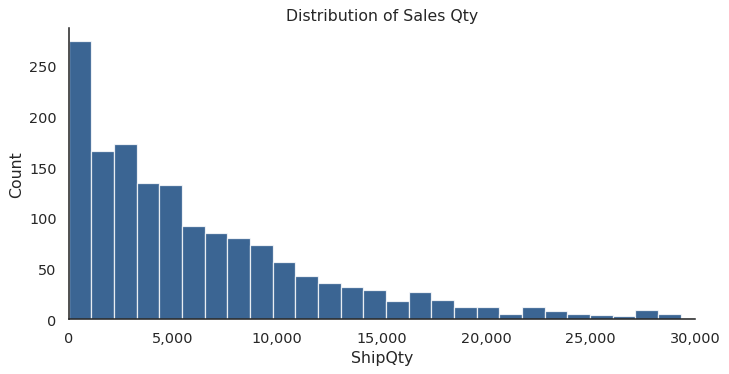

In [4]:
# set graphical parameters
# % matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 90
sns.set_context('notebook', font_scale=1.05)
sns.set_style('white')

pal = ['#066b2b', '#0a3e78', '#ae1626','#444745','#55a15a', '#5588a1', 'indianred']

fig, ax = plt.subplots(figsize = (8, 4))

ax.hist(train['ShipQty'], alpha = .8, bins=60, color = pal[1])
ax.set_title('Distribution of Sales Qty')
ax.set_ylabel('Count', fontname = 'Arial')
ax.set_xlabel('ShipQty', fontname = 'Arial')
ax.set_xlim(0, 30000)

x_vals = ax.get_xticks()
ax.set_xticklabels(['{:,.0f}'.format(x) for x in x_vals], fontname = 'Arial')

y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0f}'.format(y) for y in y_vals])

sns.despine();

* check on the sales of zero on holiday for each brand, is there any finding

In [5]:

# fig,axes=plt.subplots(1,1)
# arr_train = train['SalesQty'].to_string(index=False)

# print(type(train))
# int_train = np.asscalar(arr_train)
# arr_train=train.as_matrix()

# sns.boxplot(data= arr_train,orient="h",palette="Set3",ax=axes[1])  #水平显示 


In [6]:
train[train['ShipQty']==0].groupby(['HolidayDay','BrandCode'])['SalesQty'].aggregate('count').unstack()


BrandCode,33,34,53,74
HolidayDay,,,,
0,15.00,9.00,5.00,3.00
1,5.00,1.00,4.00,nan
2,6.00,2.00,1.00,nan
3,6.00,2.00,nan,nan
4,2.00,nan,2.00,nan
5,2.00,1.00,1.00,nan
7,10.00,2.00,2.00,nan
8,2.00,2.00,1.00,nan


`BrandCode` could be one of fact on prediction parameter, 

### ECDF: empirical cumulative distribution function

To get the first impression about continious variables in the data we can plot ECDF. from here we can see the shipment and sales keeping a very good balance. 

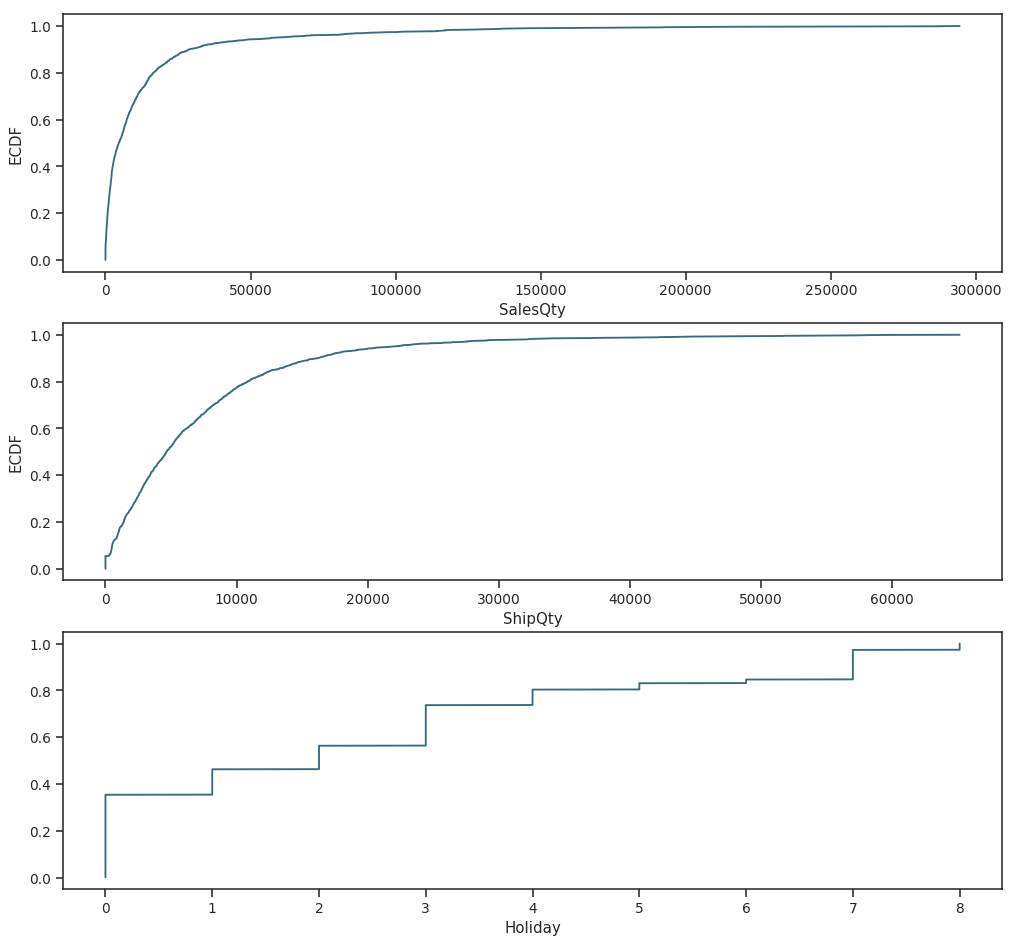

In [7]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 12))

plt.subplot(311)
cdf = ECDF(train['SalesQty'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('SalesQty'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train['ShipQty'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('ShipQty');plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train['HolidayDay'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Holiday');

About 20% of data has zero amount of sales,  30% of holiday are 3 days, shipment is less than sales qty. 

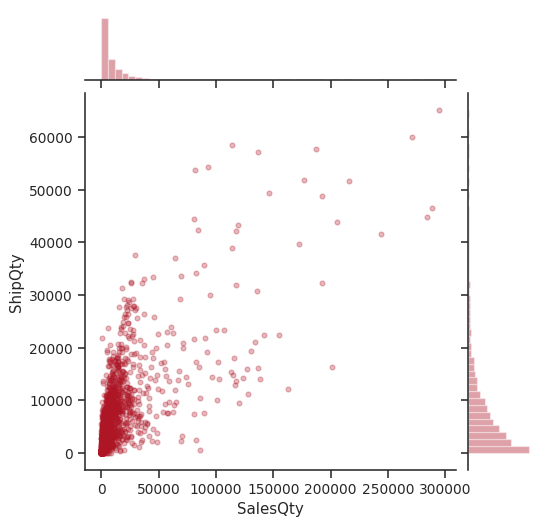

In [8]:
g= sns.jointplot(train['SalesQty'],train['ShipQty'], color=pal[2], alpha= 0.3, joint_kws={'s':15})


## Impact of Holiday on Shipment

Text(0.5, 1.0, 'Shipment of Holiday Month')

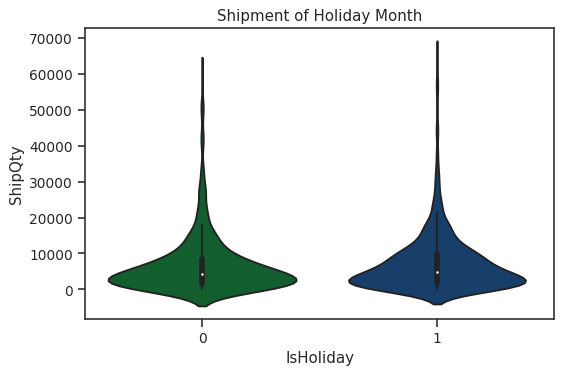

In [9]:
fig, ax = plt.subplots()
ax = sns.violinplot(x= 'IsHoliday', y = 'ShipQty', data=train, palette=pal)
ax.set_title('Shipment of Holiday Month')


- if only take look on the distrubution of shipment, there is no big difference of shipment quatities. 

/home/robin/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/robin/anaconda3/envs/ml/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


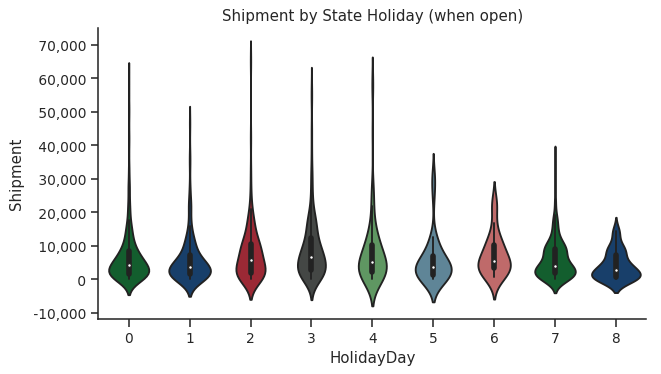

In [10]:
fig, ax = plt.subplots(figsize = (7, 4))
ax = sns.violinplot(x = 'HolidayDay', y = 'ShipQty', data = train, palette = pal)
ax.set_title('Shipment by State Holiday (when open)', fontname = 'Arial')
ax.set_ylabel('Shipment', fontname = 'Arial')


x_vals = ax.get_xticks()
ax.set_xticks(x_vals)

y_vals = ax.get_yticks()
ax.set_yticklabels([' {:,.0f}'.format(y) for y in y_vals], fontname = 'Arial')

sns.despine();

- seems there is no difference of shipment amount distribution

### Missing values or some accidents 
#### on working day of zero sales stores

In [11]:
# Sales is zero during working day
zero_workingDaySales=train[(train.ShipQty == 0) & (train.HolidayDay==0) ]
print("in total:" ,zero_workingDaySales.shape)
zero_workingDaySales.head(10)


in total: (32, 11)


,Region,ItemCode,BrandCode,Package,ShipQty,SalesQty,Year,Month,Quarter,HolidayDay,IsHoliday
YearMonth,,,,,,,,,,,
2016-07-01,East,2992101565,34,pack3,0.00,73.40,2016,7,3,0,0
2017-09-01,East,2992101565,34,pack3,0.00,1397.97,2017,9,3,0,0
2016-07-01,East,5203395462,33,pack2,0.00,0.00,2016,7,3,0,0
2016-08-01,East,5203395462,33,pack2,0.00,0.00,2016,8,3,0,0
2017-07-01,Inner,3331397693,74,pack3,0.00,487.13,2017,7,3,0,0
2017-08-01,Inner,3331397693,74,pack3,0.00,71.33,2017,8,3,0,0
2017-09-01,Inner,3331397693,74,pack3,0.00,0.00,2017,9,3,0,0
2015-11-01,Inner,6288617494,33,pack4,0.00,0.00,2015,11,4,0,0
2015-12-01,Inner,6288617494,33,pack4,0.00,0.00,2015,12,4,0,0


,Year,Month,ShipQty
count,32.00,32.00,32.00
mean,2015.84,9.56,0.00
std,1.02,2.03,0.00
min,2014.00,6.00,0.00
25%,2015.00,7.75,0.00
50%,2016.00,11.00,0.00
75%,2017.00,11.00,0.00
max,2017.00,12.00,0.00


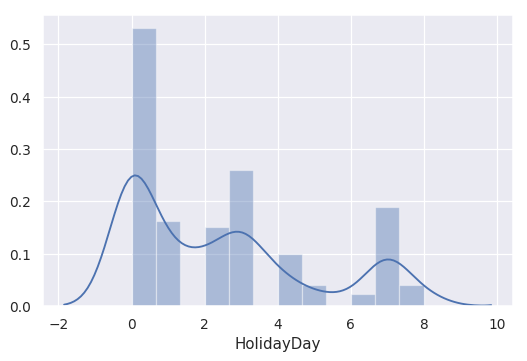

In [12]:
sns.set(style="darkgrid")
sns.distplot(train.HolidayDay)
train[(train.ShipQty==0)&(train.HolidayDay==0)].loc[:,['Year','Month','ShipQty']].describe()

There're 33 stores with zero sales in the data __during working day__. It is about 0.2% of the total amount of observations. there are some facts involved, maybe is the manifestations. To avoid any biased , we want see the distribution of the data.  


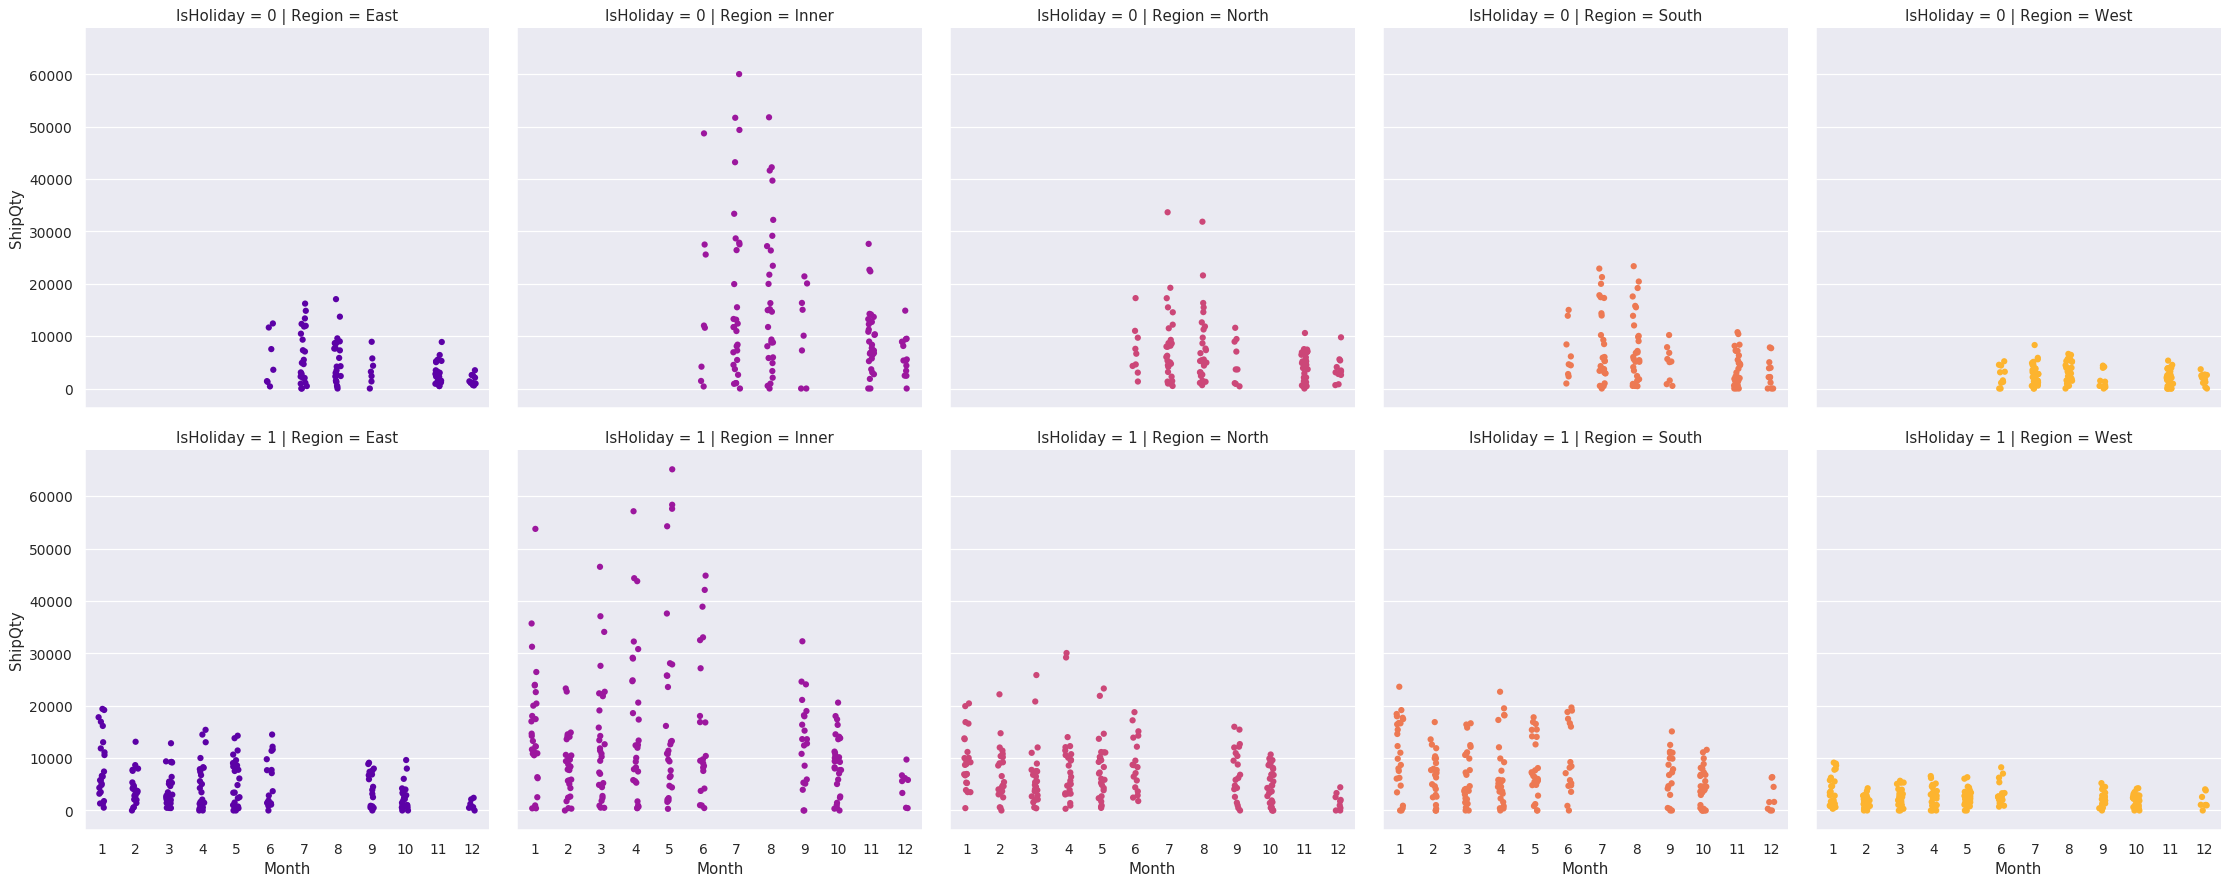

In [13]:
# sales trends
c = '#386B7F'
sns.catplot(data = train, x = 'Month', y = "ShipQty", 
               col = 'Region', # per region type in cols
               palette = 'plasma',
               hue = 'Region',
               row = 'IsHoliday', # per promo in the store in rows
               color = c) 

##### - very interesting finding, before holiday and after holiday, very easy to see the shipment got increace

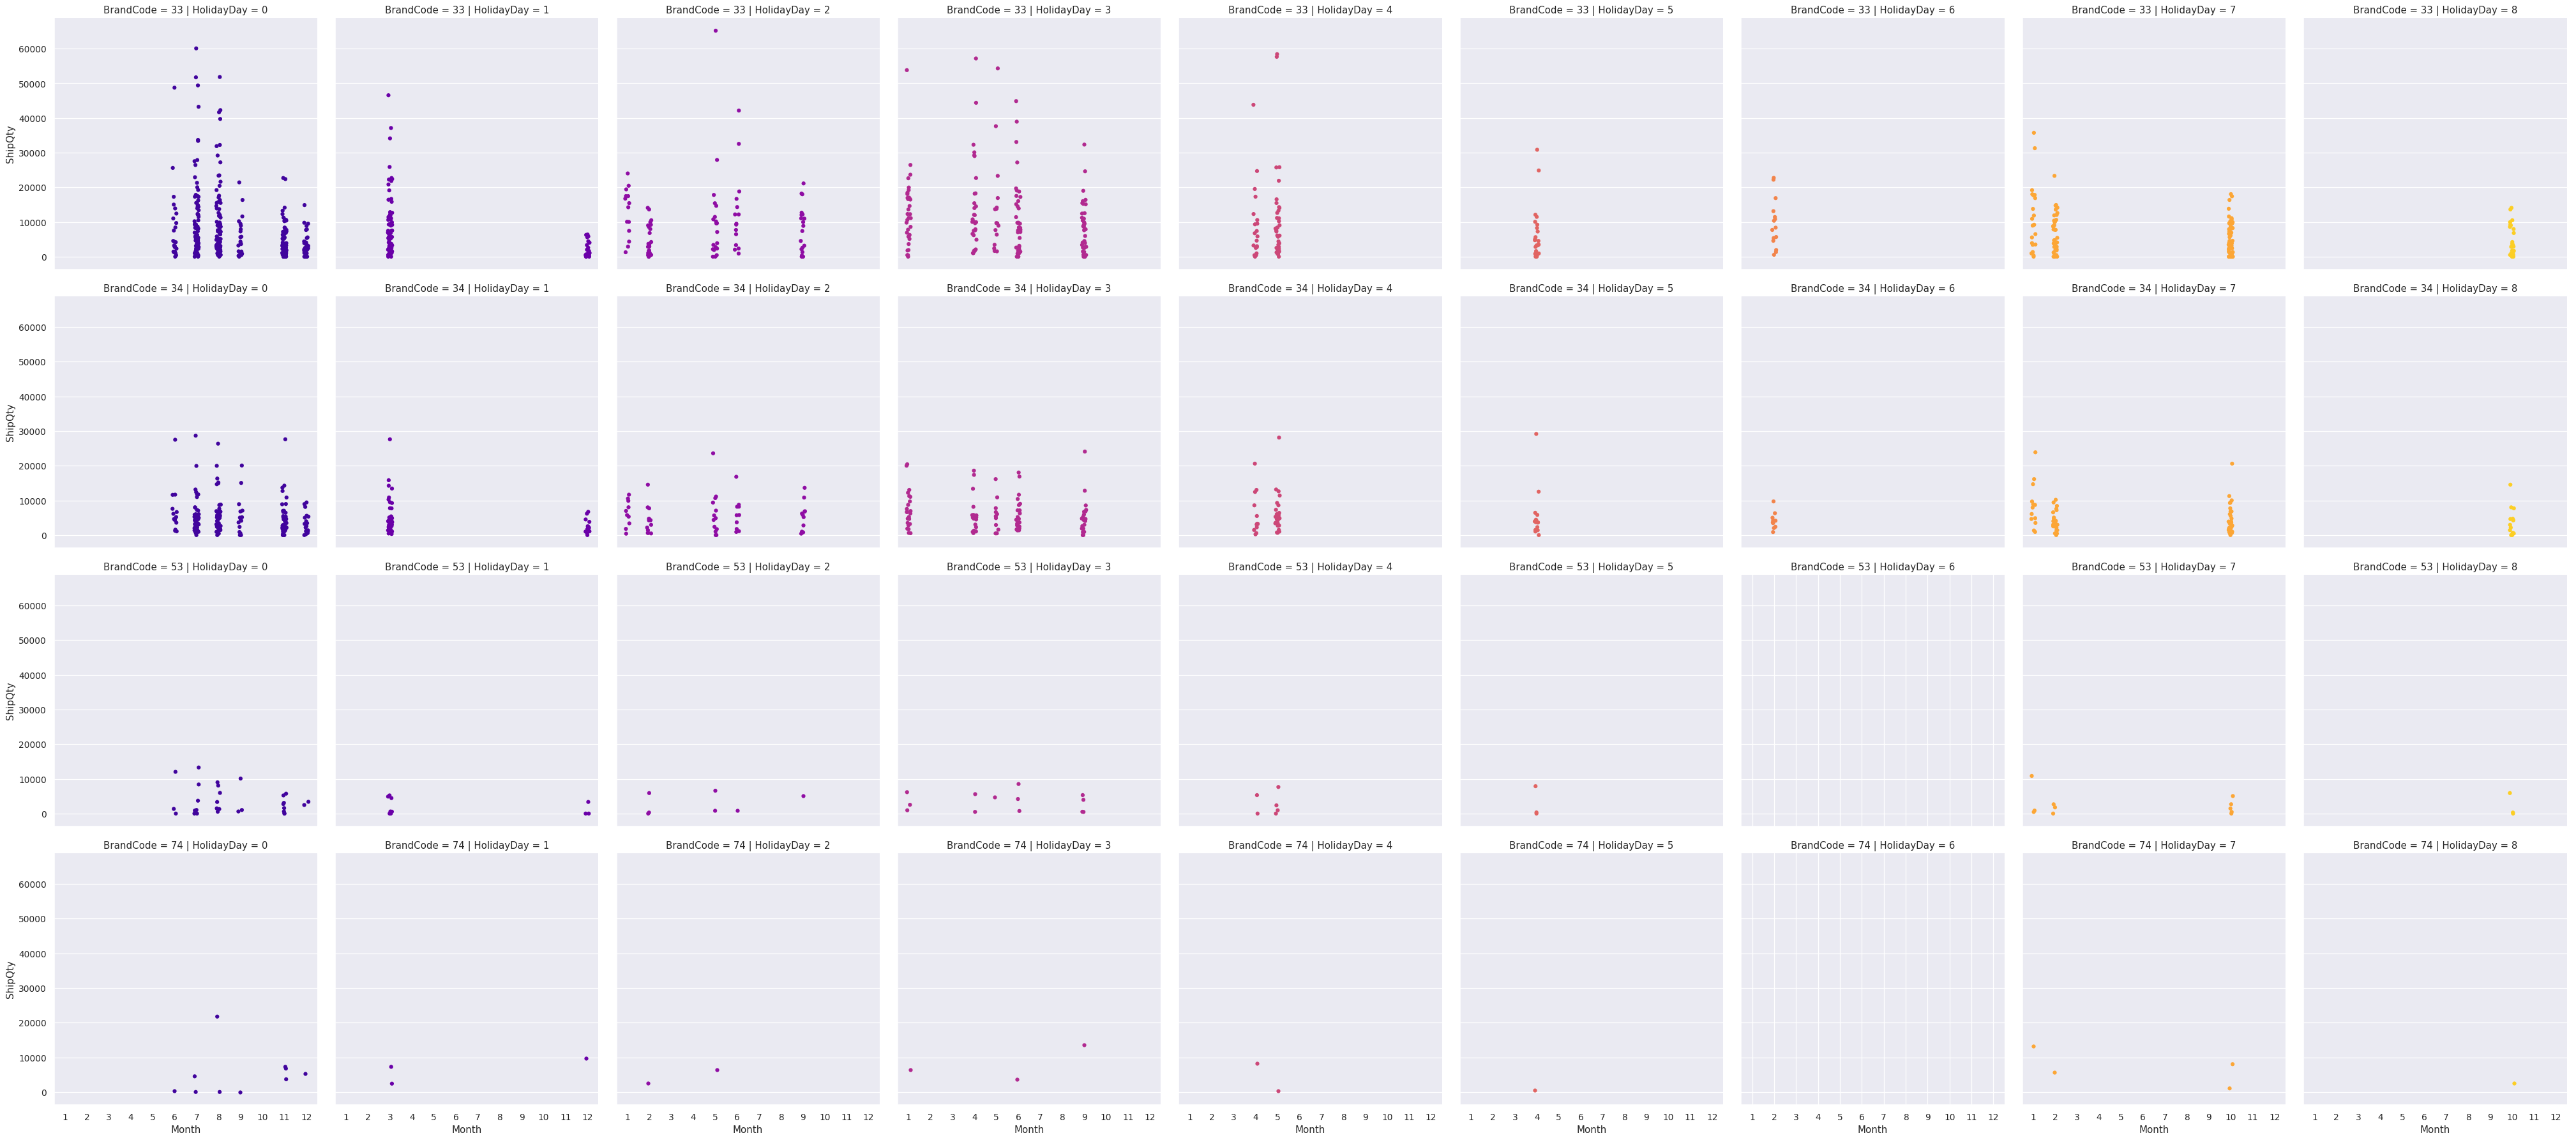

In [14]:
# sale per BrandCode trends
sns.catplot(data = train, x = 'Month', y = "ShipQty", 
               col = 'HolidayDay', # per HolidayDays in cols
               palette = 'plasma',
               hue = 'HolidayDay',
               row = 'BrandCode',
              
               color = c) 

the correlation of SalesQty & Days of Holiday　&　Brand are show that, those three feature are impact sales very much. `BrandCode = 33` is very popular. 

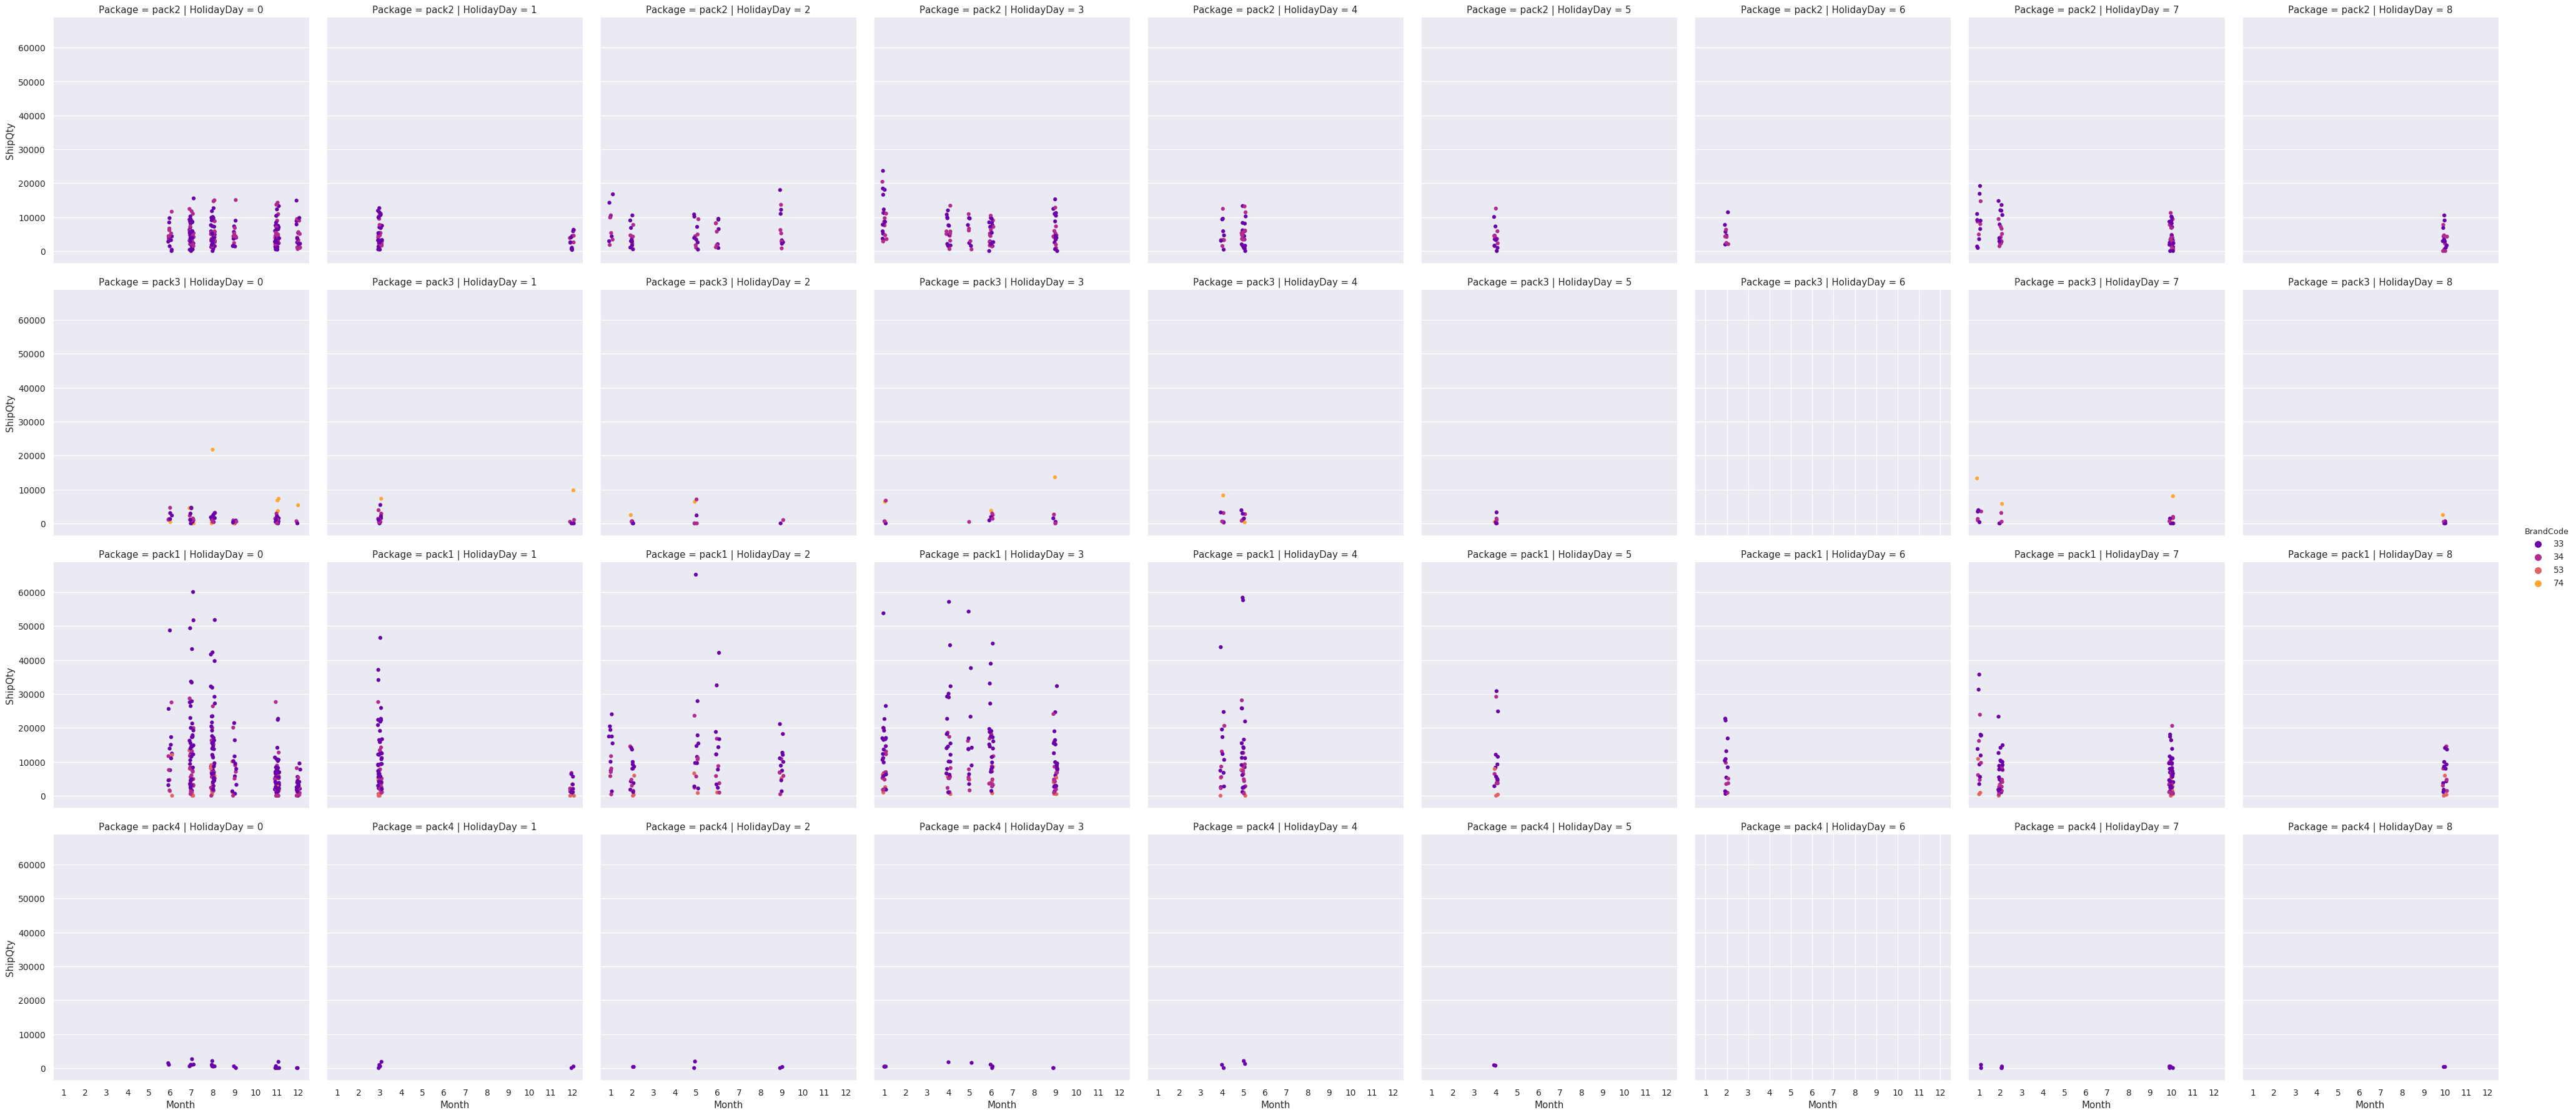

In [15]:
# sale per sales trends
sns.catplot(data = train, x = 'Month', y = "ShipQty", 
               col = 'HolidayDay', # per HolidayDays in cols
               palette = 'plasma',
               hue = 'BrandCode',
               row = 'Package',
              
               color = c) 

We see that package is also correlative to sales. `package 1` is very positive correlative to each brand

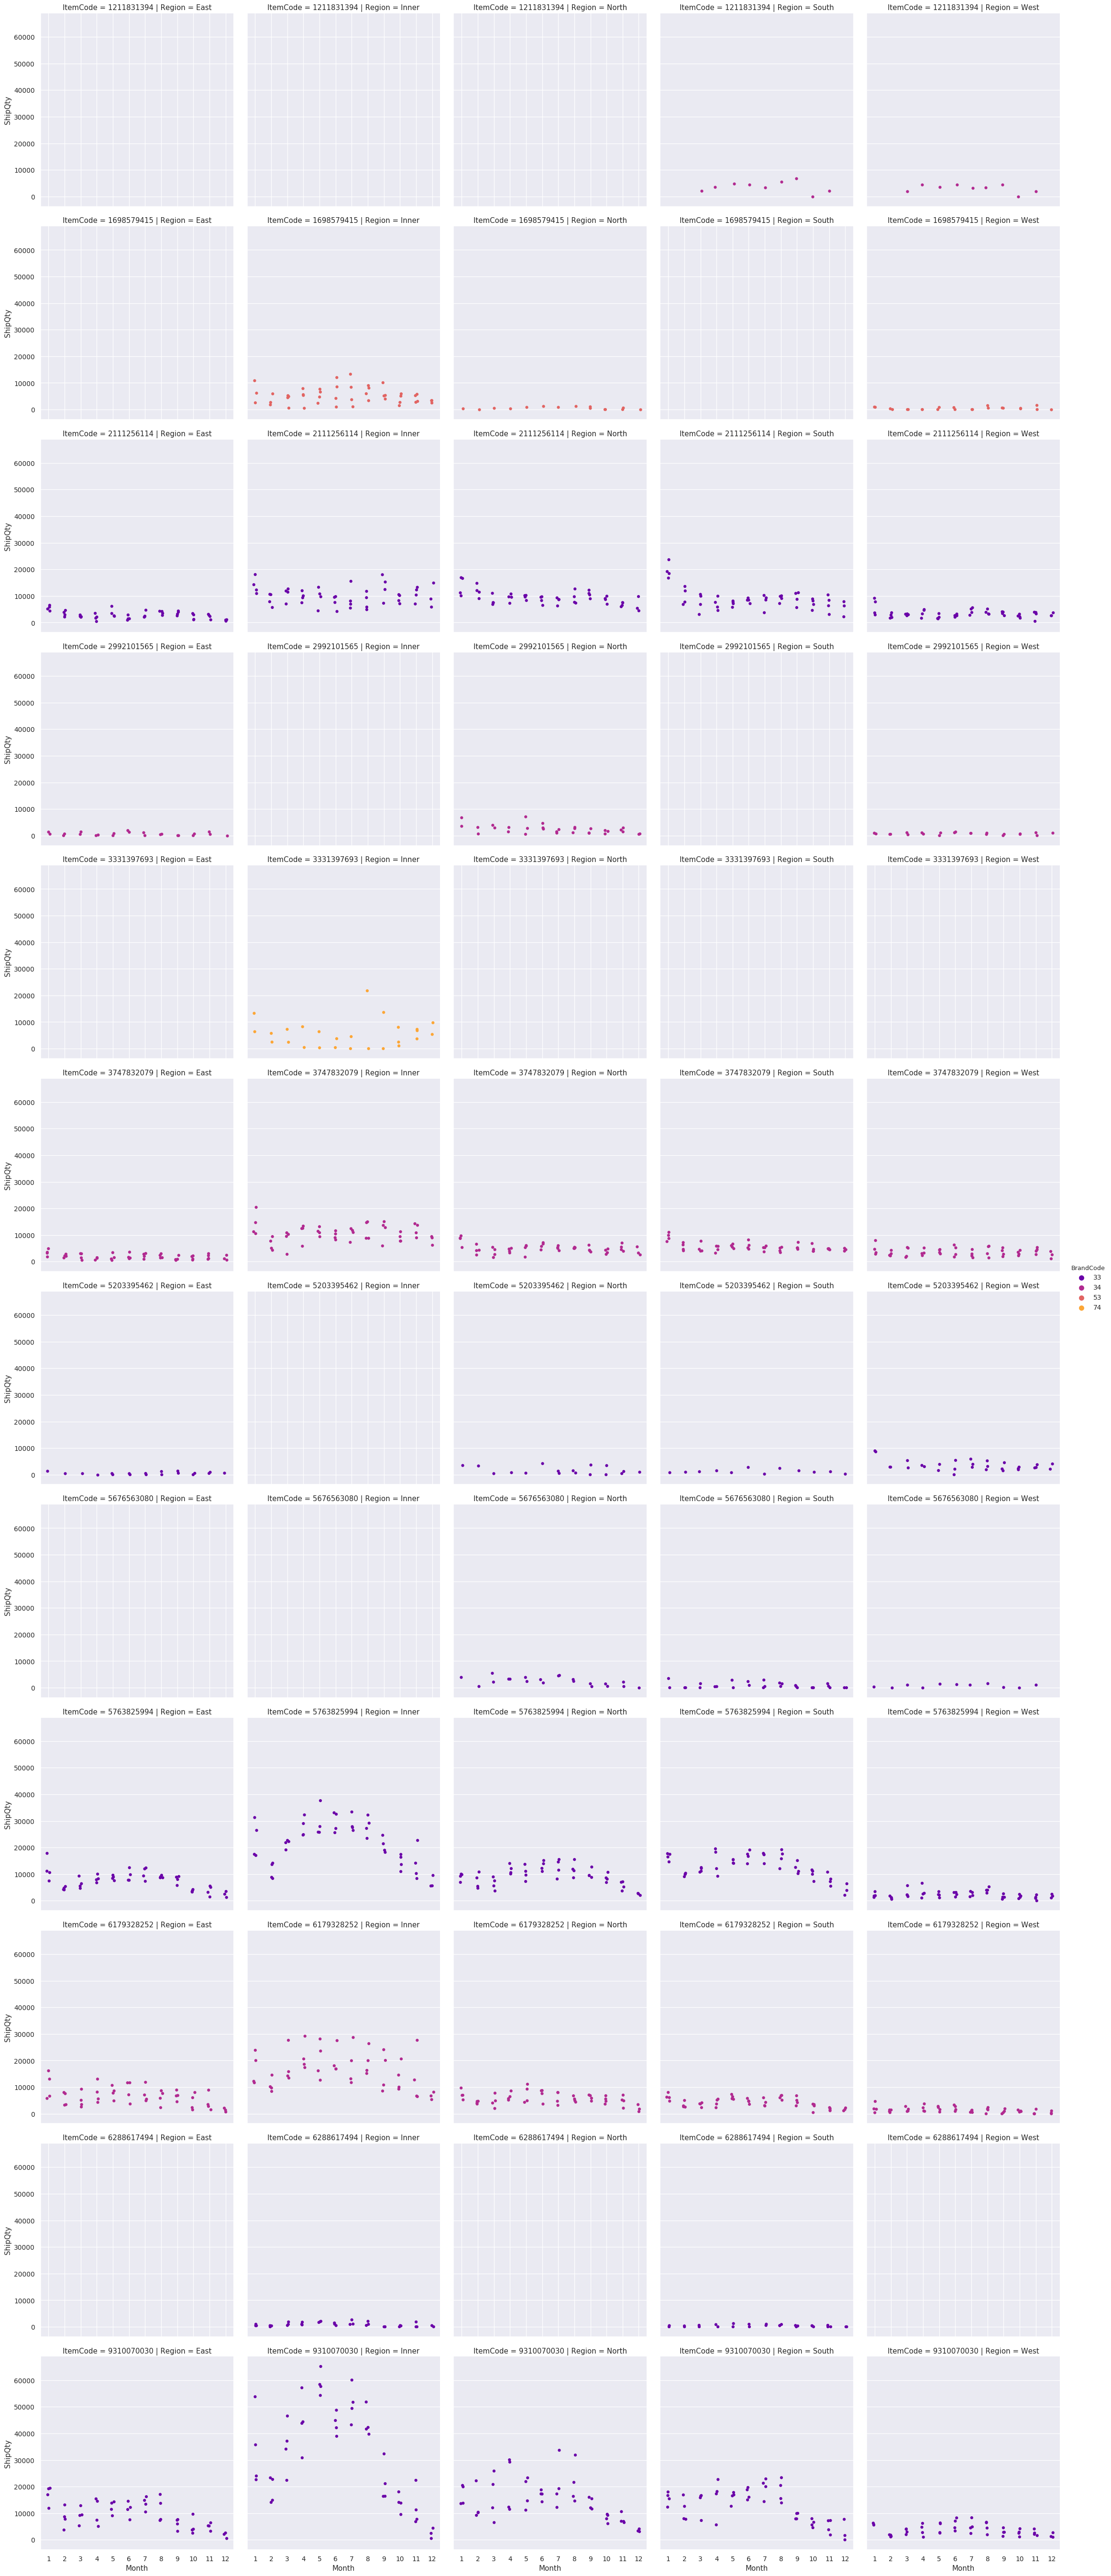

In [16]:
# sale per customer trends
sns.catplot(data = train, x = 'Month', y = "ShipQty", 
               col = 'Region', # per HolidayDays in cols
               palette = 'plasma',
               hue = 'BrandCode',
               row = 'ItemCode',
              
               color = c) 

- interesting finding, the `Item code` is very  big defference of `sales` in each ereas. like eg. in east area, `ItemCode= 1698579415, ItemCode = 1211831394` got no sales. 

### Correlational Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the `seaborn` heatmap:

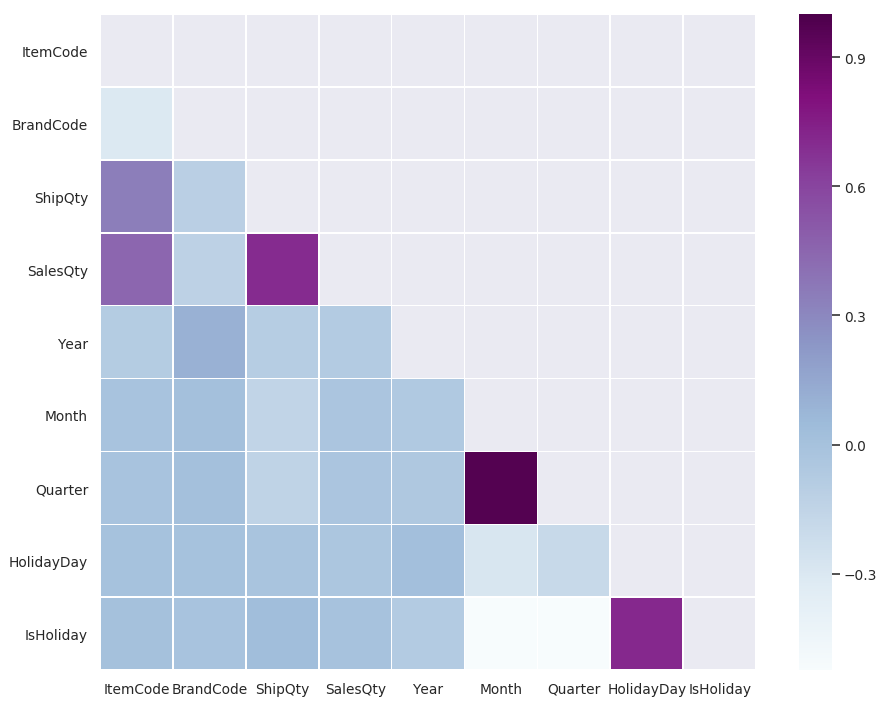

In [17]:
# Compute the correlation matrix 

corr_all = train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

As mentioned before, we have a strong positive correlation between the `ItemCode` and  `SalesQty` .  We can also observe a positive correlation between the `shipQty`  and  `ItemCode`. 


There are several things here:
- In case of holiday,  `Shipment` tend to peak(!). Though we should note that `Holiday` on different month is affecting Sales. So it is mainly data from `Holiday` . and if holiday day is `three` days, the sales keep close to peak (!).
- On the contrary, stores that during working day tend to make most of the `Sales` on `east` and `inner` duing month of `6,7,8,9,11,12` .  The same trend follow the stores which have different `package` specially for `package1` and `package2`
- `Itemcode` alone `9310070030` seem to be correlated to any significant change in the `Shipment` amount. This can be also prooved by the blue pale area on the heatmap above which is `ItemCode` is very positive correlation with the `shipQty` and `SalesQty`

---

## Conclusion of EDA

- The most selling and crowded `ItemCode` is `9310070030`.


- The best "Sale per Region"  is `east` and `inner`. We could also assume that the stores of this types are situated in the central city or tie one areas, so that customers buying behavior is not that sensitive of holiday. not only small volumns or big volumns. 


- Low `SalesQty` amount for `Region` indicates to the possible fact that people shop there essentially for small things. Which can also indicate to the label of this store type - "urban" - as it's more accessible for public, and customers don't mind shopping there from time to time during a week.


- Customers tends to buy more on `Month` of `Holiday`, when there is no holiday month at all the sales of that month close to `zero`.





## Time-Series Analysis per Store Type

What makes a time series different from a regular regression problem? 

- It is time dependent. The basic assumption of a linear regression that the observations are independent doesn’t hold in this case.


- Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for China Spring festival holidays, which we will see in this dataset.

<div class = "alert alert-block alert-info"> We build a time series analysis on region instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonaltities in the dataset. </div>

### Seasonality

We take five region from regions to represent their group:
- region number 1 for `Region` East
- region number 2 for `Region` Inner, 
- region number 3 for `Region` West 
- region number 4 for `Region` North.
- region number 5 for `Region` South. 


It also makes sense to downsample the data from days to weeks using the `resample` method to see the present trends more clearly.

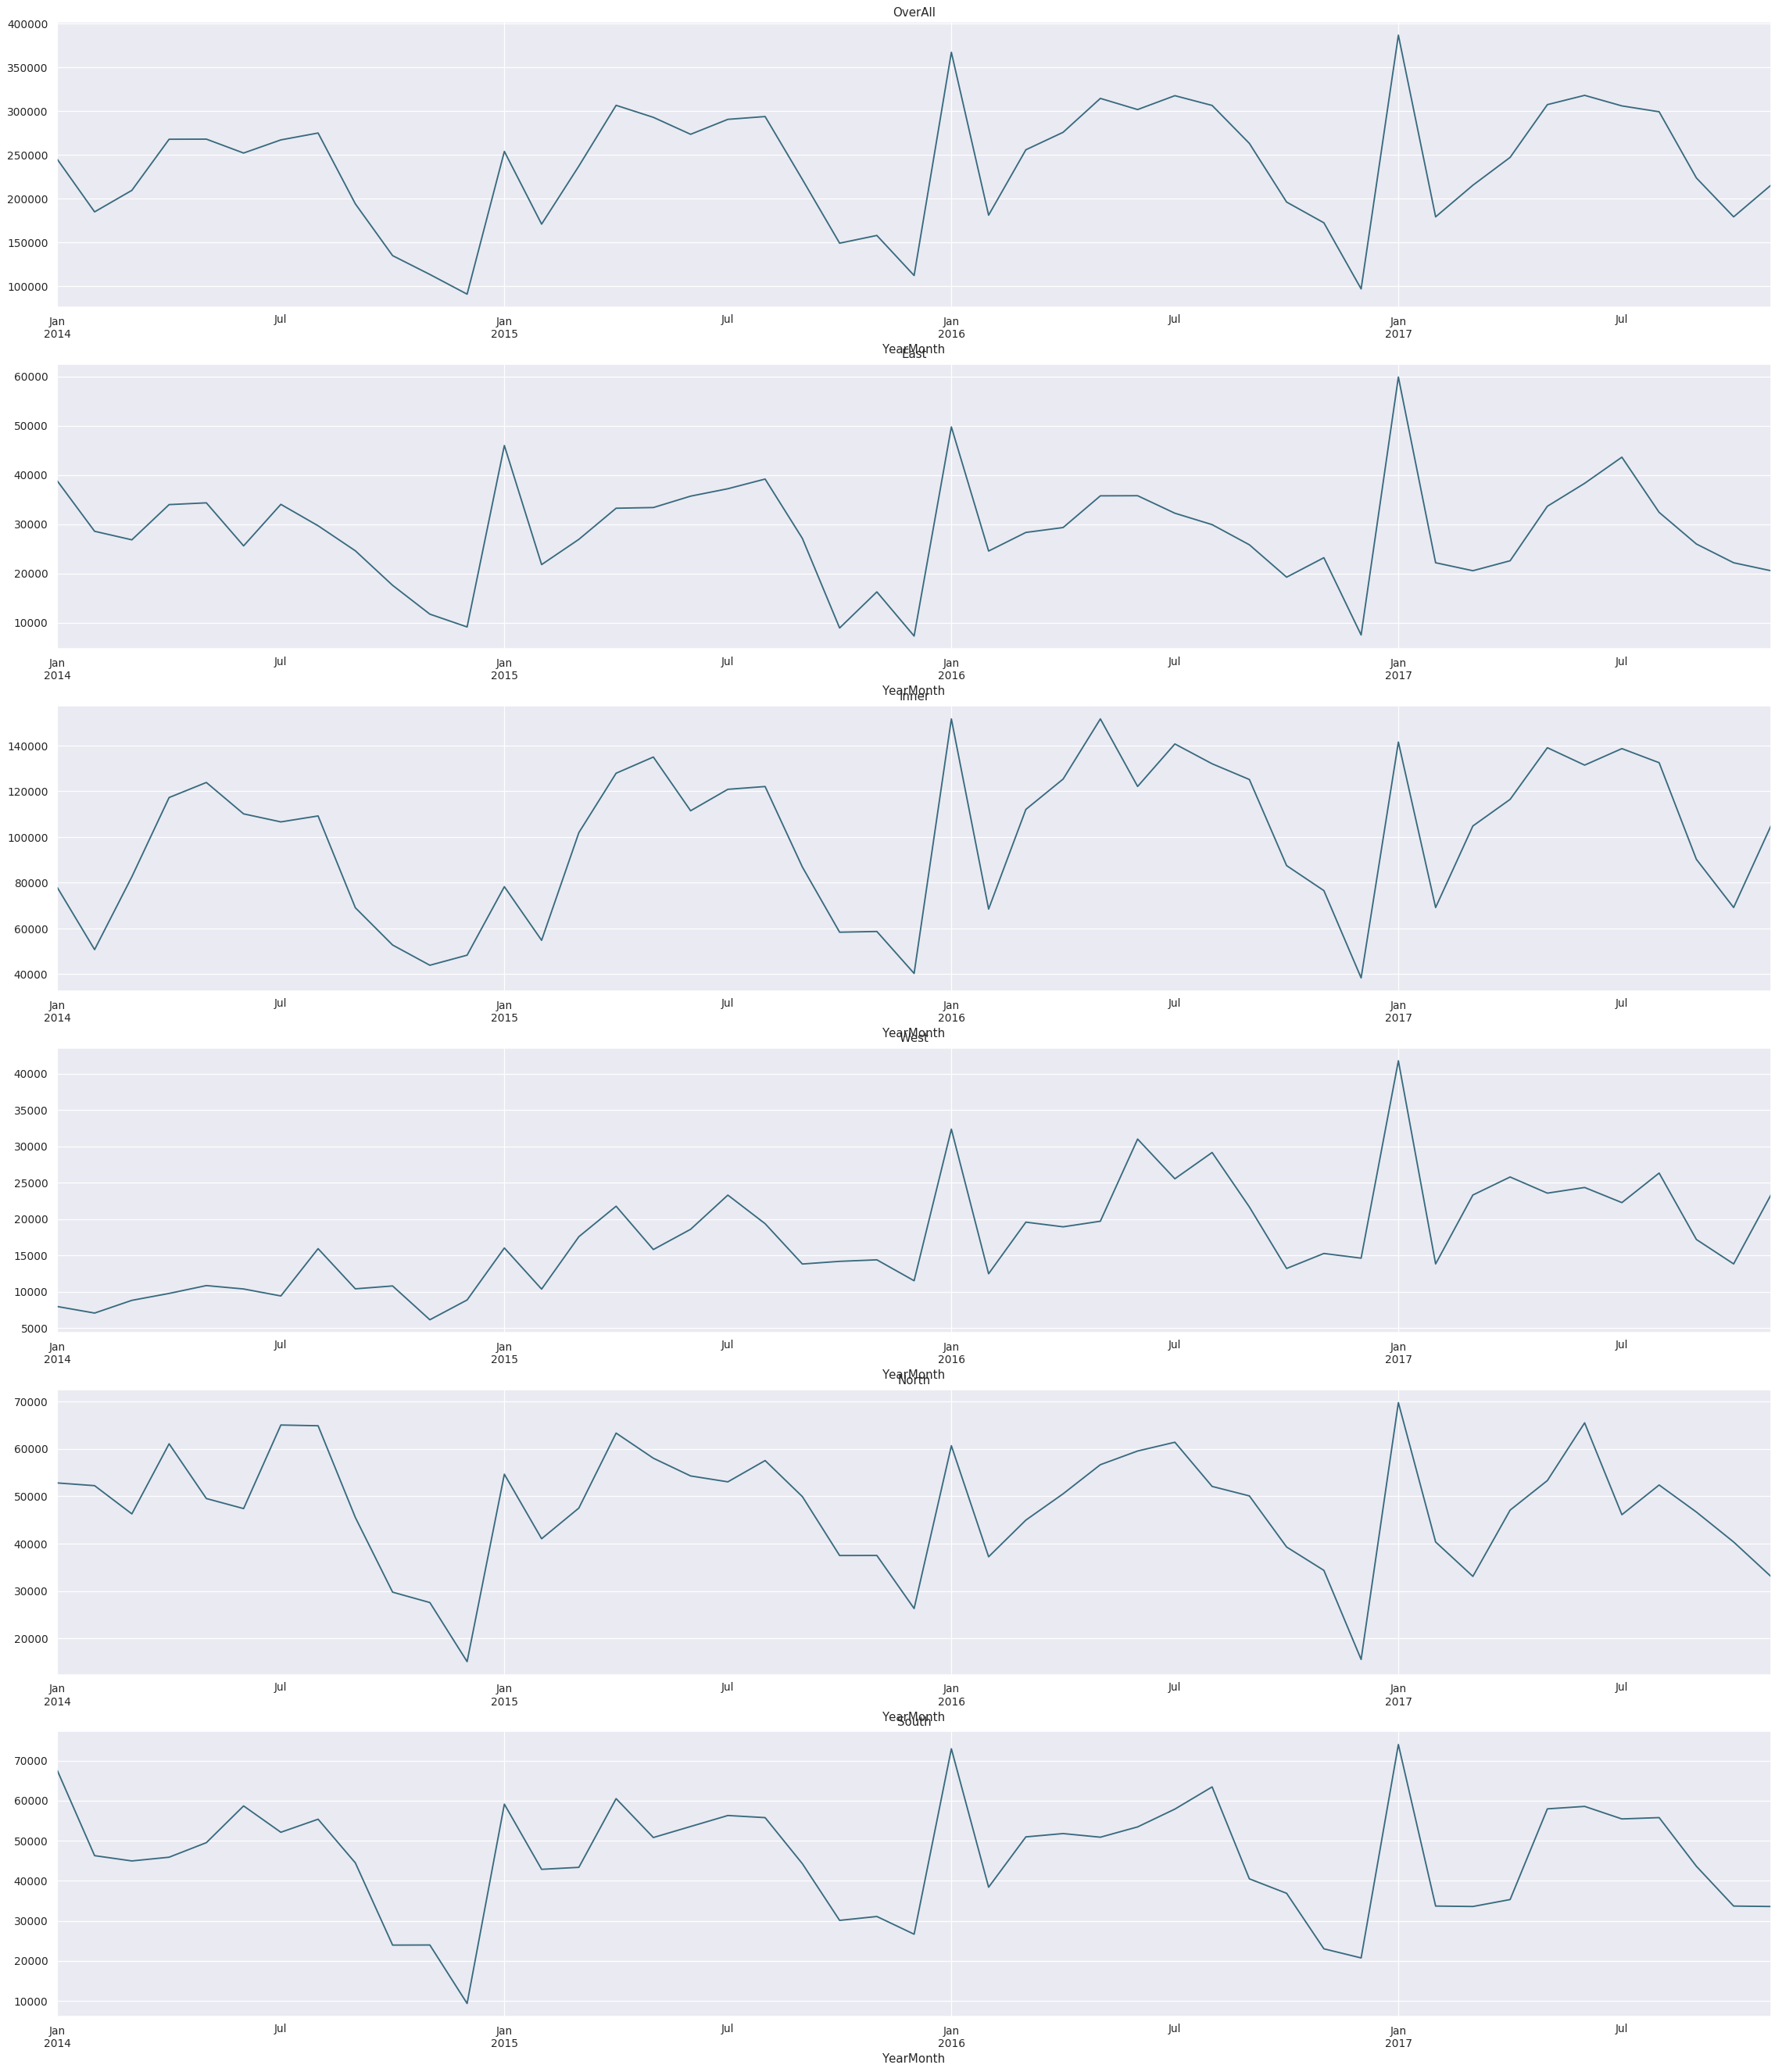

In [18]:
# preparation: input should be float type
train['SalesQty'] = train['SalesQty'] * 1.0

# sales types
sales_0 = train['ShipQty']
sales_1 = train[train.Region == 'East']['ShipQty']
sales_2 = train[train.Region == 'Inner']['ShipQty']
sales_3 = train[train.Region == 'West']['ShipQty']
sales_4 = train[train.Region == 'North']['ShipQty']
sales_5 = train[train.Region == 'South']['ShipQty']

f, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(6, figsize = (28, 35))

# area types
sales_0.resample('M').sum().plot(color = c, ax = ax0, title='OverAll')
sales_1.resample('M').sum().plot(color = c, ax = ax1, title='East')
sales_2.resample('M').sum().plot(color = c, ax = ax2, title='Inner')
sales_3.resample('M').sum().plot(color = c, ax = ax3, title='West')
sales_4.resample('M').sum().plot(color = c, ax = ax4, title='North')
sales_5.resample('M').sum().plot(color = c, ax = ax5, title='South')

<div class = "alert alert-block alert-success"> the sales of each area can see peek are quite diffent during year. for East aear, peek is coming at first year, for West area, peak is coming at 2016, for Inner peak is coming at 2017, for North area, the peak is keeping very good trend, for south area, the peak is coming at first two at 2015  </div>

### Autocorrelaion

The next step in ourtime series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. 

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4. 

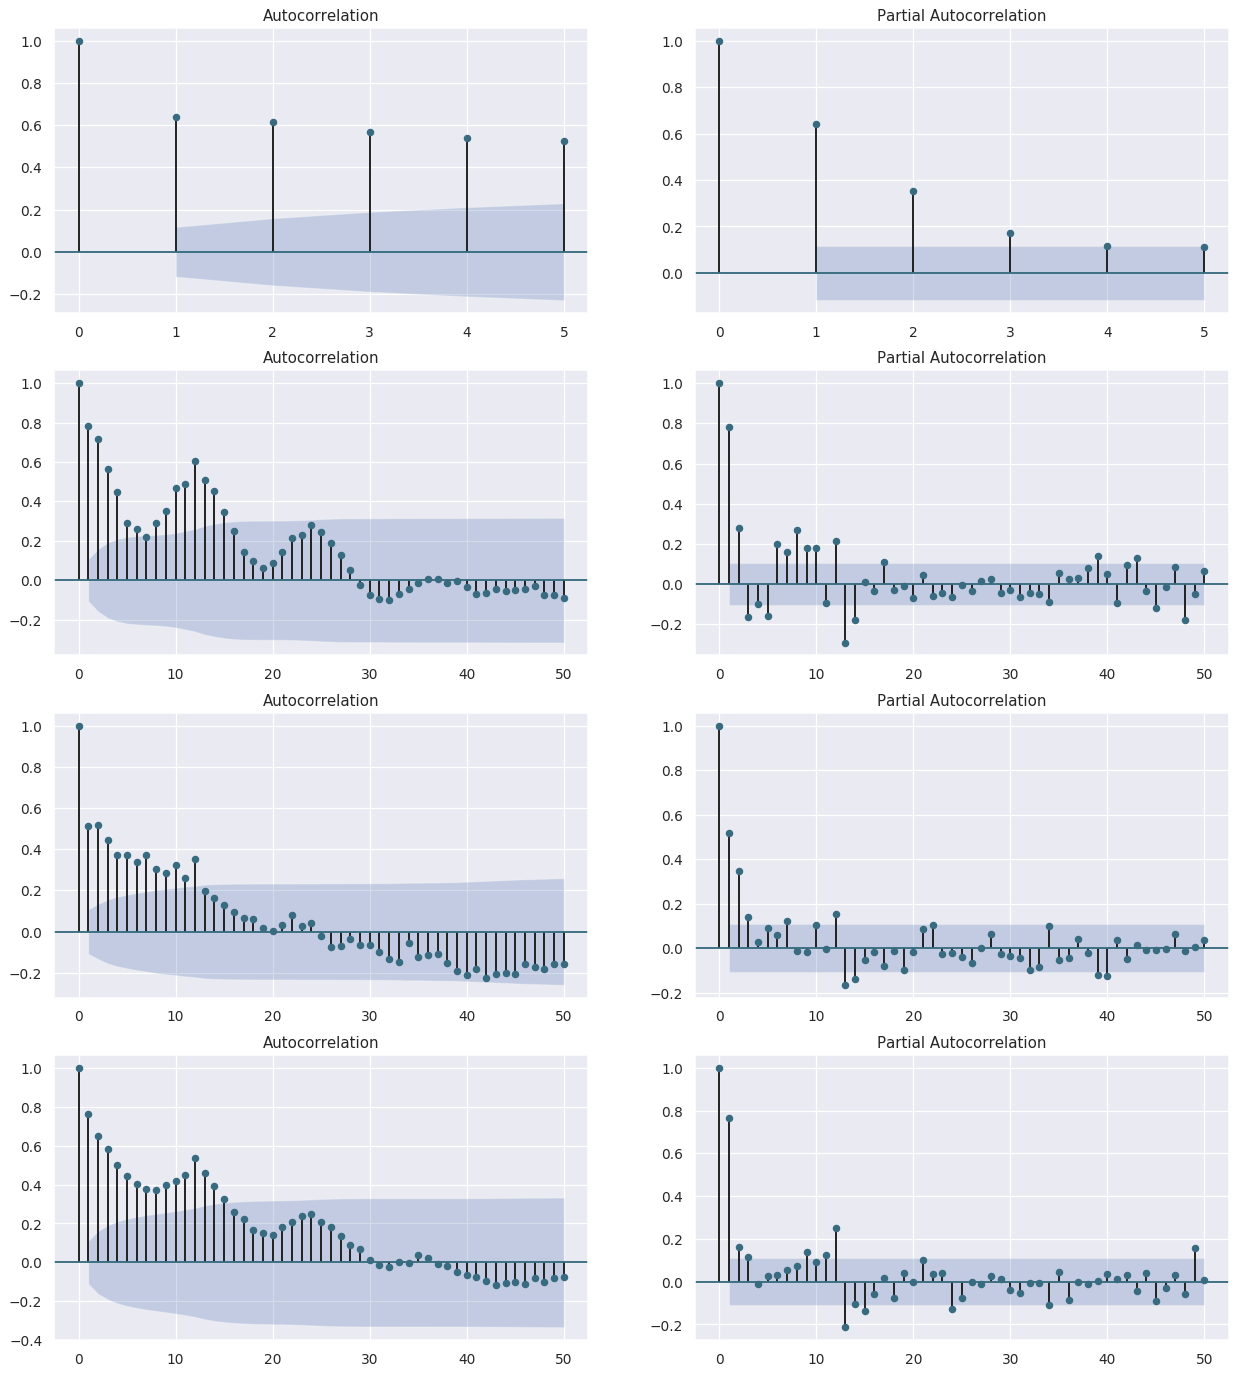

In [19]:
# figure for subplots
plt.figure(figsize = (15, 18))

# acf and pacf for East
plt.subplot(421); plot_acf(sales_1, lags = 5, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_1, lags = 5, ax = plt.gca(), color = c)

# acf and pacf for West
plt.subplot(423); plot_acf(sales_2, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_2, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for Inner
plt.subplot(425); plot_acf(sales_3, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_3, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for North
plt.subplot(427); plot_acf(sales_4, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_4, lags = 50, ax = plt.gca(), color = c)


plt.show()



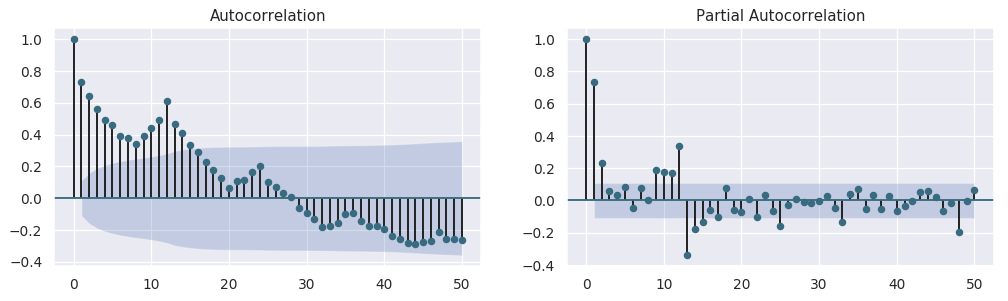

In [20]:
plt.figure(figsize=(12,15))

# acf and pacf for South
plt.subplot(425); plot_acf(sales_5, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_5, lags = 50, ax = plt.gca(), color = c)
plt.show()

We can read these plots horizontally. Each horizontal pair is for one 'Region', from East to South. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

Falters ACF has trailing characteristics, PACF truncated features, the AR model is more reasonable, if PACF trailing characteristics, ACF has truncated characteristics, the MA model is more reasonable,

There is at two things common for each pair of plots: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).


## Time Series Analysis and Forecasting with Prophet
#### Forecasting for the next month for the first store

The Core Data Science team at Facebook recently published a new procedure for forecasting time series data called [Prophet](https://research.fb.com/prophet-forecasting-at-scale/). It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It enables performing [automated forecasting which are already implemented in R](https://www.rdocumentation.org/packages/forecast/versions/7.3/topics/auto.arima) at scale in Python 3.

In [40]:
# importing data
df = pd.read_csv("/home/robin/Documents/data-sci/C_Team/sales_forcecasting/sales_forcecast/EDA-master/data/ResultDataMonth.csv",  
                    low_memory = False)

shipment = df.loc[:,['YearMonth','ShipQty','ItemCode','Region','BrandCode']]

# shipment for the area East 
shipment_east = df[df.Region == 'East'].loc[:, ['YearMonth', 'ShipQty','ItemCode','Region','BrandCode','SalesQty']]
# shipment for the area West 
shipment_west = df[df.Region == 'West'].loc[:, ['YearMonth', 'ShipQty']]
# shipment for the area Inner 
shipment_inner = df[df.Region == 'Inner'].loc[:, ['YearMonth', 'ShipQty']]
# shipment for the area South 
shipment_south = df[df.Region == 'South'].loc[:, ['YearMonth', 'ShipQty']]
# shipment for the area North 
shipment_north = df[df.Region == 'North'].loc[:, ['YearMonth', 'ShipQty']]


# reverse to the order: from 2014 to 2017
shipment_east = shipment_east.sort_index(ascending = False)
shipment_west = shipment_west.sort_index(ascending = False)
shipment_inner = shipment_inner.sort_index(ascending = False)
shipment_south = shipment_south.sort_index(ascending = False)
shipment_north = shipment_north.sort_index(ascending = False)

# to datetime64
shipment_east['YearMonth'] = pd.DatetimeIndex(shipment_east['YearMonth'])
shipment_west['YearMonth'] = pd.DatetimeIndex(shipment_west['YearMonth'])
shipment_inner['YearMonth'] = pd.DatetimeIndex(shipment_inner['YearMonth'])
shipment_north['YearMonth'] = pd.DatetimeIndex(shipment_north['YearMonth'])
shipment_south['YearMonth'] = pd.DatetimeIndex(shipment_south['YearMonth'])


shipment_east.dtypes
shipment_west.dtypes
shipment_inner.dtypes
shipment_north.dtypes
shipment_south.dtypes

YearMonth    datetime64[ns]
ShipQty             float64
dtype: object

In [41]:
# from the prophet documentation every variables should have specific names
shipment_east = shipment_east.rename(columns = {'YearMonth': 'ds',
                                'ShipQty': 'y'})
shipment_west = shipment_west.rename(columns = {'YearMonth': 'ds',
                                'ShipQty': 'y'})
shipment_inner = shipment_inner.rename(columns = {'YearMonth': 'ds',
                                'ShipQty': 'y'})
shipment_north = shipment_north.rename(columns = {'YearMonth': 'ds',
                                'ShipQty': 'y'})
shipment_south = shipment_south.rename(columns = {'YearMonth': 'ds',
                                'ShipQty': 'y'})
shipment = shipment.rename(columns={'YearMonth':'ds','ShipQty':'y'})
# print(shipment_east.head())
# print(shipment_west.head())
# print(shipment_inner.head())
# print(shipment_north.head())
# print(shipment_south.head())
print(shipment_east)


            ds        y    ItemCode Region  BrandCode  SalesQty
276 2017-11-01  5275.64  9310070030   East         33   7316.96
275 2017-10-01  3699.54  9310070030   East         33  48137.13
274 2017-09-01  3212.00  9310070030   East         33  41899.69
273 2017-08-01  7661.62  9310070030   East         33  89875.31
272 2017-07-01 10473.85  9310070030   East         33  86099.38
271 2017-06-01  7530.88  9310070030   East         33  57219.81
270 2017-05-01  9052.26  9310070030   East         33  63550.07
269 2017-04-01  5045.24  9310070030   East         33  34047.68
268 2017-03-01  5275.64  9310070030   East         33  29341.89
267 2017-02-01  3699.54  9310070030   East         33  18262.31
266 2017-01-01 11859.52  9310070030   East         33  33053.86
265 2016-12-01   509.92  9310070030   East         33  16136.97
264 2016-11-01  5198.57  9310070030   East         33  31336.88
263 2016-10-01  4005.42  9310070030   East         33  11932.75
262 2016-09-01  5967.92  9310070030   Ea

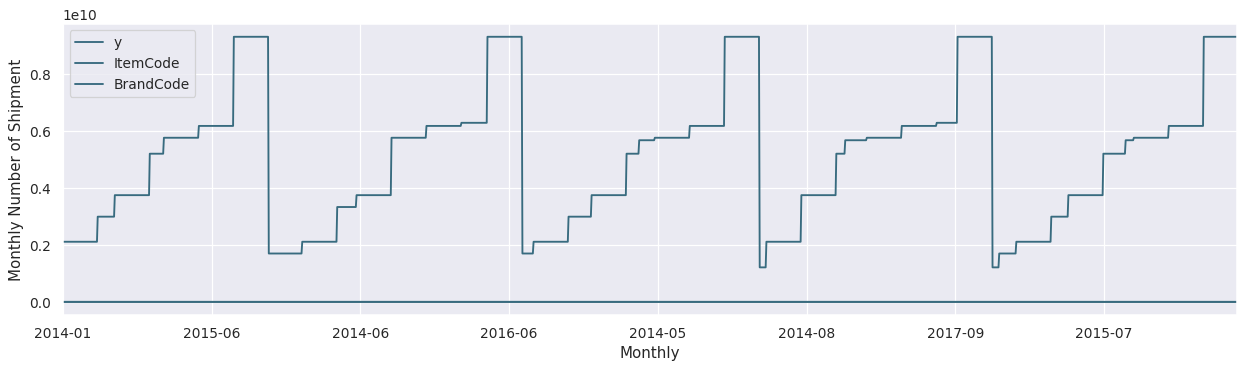

In [42]:
# plot Monthly shipment
ax = shipment.set_index('ds').plot(figsize = (15, 4), color = c)
ax.set_ylabel('Monthly Number of Shipment')
ax.set_xlabel('Monthly')
plt.show()

### Modeling Holidays

Prophet also allows to [model for holidays](https://facebookincubator.github.io/prophet/docs/holiday_effects.html), and that's what we do here.

The StateHoliday variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the dataset at which ceratin stores are also closing their doors.

In [43]:
# create holidays dataframe
state_dates = df[(df.HolidayDay == 1) | (df.HolidayDay == 2) |(df.HolidayDay == 3)|(df.HolidayDay == 4)|(df.HolidayDay == 5)|(df.HolidayDay == 6) |(df.HolidayDay == 7)|(df.HolidayDay == 8)& (df.HolidayDay>0)].loc[:, 'YearMonth'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
holidays = pd.DataFrame(state)
holidays.head(50)

,holiday,ds
0,state_holiday,2014-01-01
1,state_holiday,2014-02-01
2,state_holiday,2014-03-01
3,state_holiday,2014-04-01
4,state_holiday,2014-05-01
5,state_holiday,2014-06-01
6,state_holiday,2014-09-01
7,state_holiday,2014-10-01
8,state_holiday,2015-01-01
9,state_holiday,2015-02-01


In [44]:
# set the uncertainty interval to 95% (the Prophet default is 80%)

#all area model fit
shipment_model = Prophet(interval_width=0.60, holidays=holidays)
shipment_model.fit(shipment)

#east model fit 
east_model = Prophet(interval_width = 0.9, holidays=holidays
                   )
east_model.fit(shipment_east)
#west model fit
west_model = Prophet(interval_width = 0.80, 
                   holidays = holidays)
west_model.fit(shipment_west)
#inner model fit
inner_model = Prophet(interval_width = 0.80, 
                   holidays = holidays)
inner_model.fit(shipment_inner)
#north_model fit
north_model = Prophet(interval_width = 0.80, 
                   holidays = holidays)
north_model.fit(shipment_north)
#sourth_model fit
south_model = Prophet(interval_width = 0.80, 
                   holidays = holidays)
south_model.fit(shipment_south)



# dataframe that extends into future 6 month 
future_dates = shipment_model.make_future_dataframe(periods = 6, freq='M')
# east_future_dates = east_model.make_future_dataframe(periods = 2, freq='M')
# west_future_dates = west_model.make_future_dataframe(periods = 2, freq='M')
# inner_future_dates = inner_model.make_future_dataframe(periods = 2, freq='M')
# north_future_dates = north_model.make_future_dataframe(periods = 2, freq='M')
# south_future_dates = south_model.make_future_dataframe(periods = 30, freq='M')

print("First month to forecast.")
# east_future_dates.tail(7)
# west_future_dates.tail(7)
# inner_future_dates.tail(7)
# north_future_dates.tail(7
# south_future_dates.tail(50)
future_dates.tail(6)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

First month to forecast.


,ds
1580,2017-11-30
1581,2017-12-31
1582,2018-01-31
1583,2018-02-28
1584,2018-03-31
1585,2018-04-30


In [45]:
# predictions
forecast = east_model.predict(future_dates)

# preditions for last month
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
1580,2017-11-30,641.82,-5901.51,6883.27
1581,2017-12-31,7111.48,935.14,13782.26
1582,2018-01-31,2796.61,-3726.59,9047.12
1583,2018-02-28,3110.89,-3576.84,9394.98
1584,2018-03-31,3872.60,-2434.12,10422.65
1585,2018-04-30,4405.99,-2059.60,10530.88


In [46]:
# predictions
forecast = west_model.predict(future_dates)
# print(forecast)
# preditions for last month
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)



,ds,yhat,yhat_lower,yhat_upper
1580,2017-11-30,1686.52,-545.58,4038.96
1581,2017-12-31,3266.21,1067.22,5376.04
1582,2018-01-31,1094.99,-978.13,3344.96
1583,2018-02-28,2013.38,-372.06,4261.35
1584,2018-03-31,2269.33,86.94,4554.45
1585,2018-04-30,2034.06,-181.42,4163.33


In [47]:
# predictions
forecast = inner_model.predict(future_dates)

# preditions for last month
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
1580,2017-11-30,5977.28,-10237.06,21544.25
1581,2017-12-31,16357.19,1171.19,31293.44
1582,2018-01-31,8752.96,-6939.35,24670.30
1583,2018-02-28,13915.03,162.21,28657.47
1584,2018-03-31,17161.56,1491.65,33864.61
1585,2018-04-30,19068.21,3653.84,34309.95


In [48]:
# predictions
forecast = north_model.predict(future_dates)

# preditions for last month
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
1580,2017-11-30,401.57,-5734.79,6810.22
1581,2017-12-31,6643.48,308.05,12955.53
1582,2018-01-31,3729.37,-3228.95,10134.81
1583,2018-02-28,3747.07,-3246.39,10167.05
1584,2018-03-31,5787.88,-460.16,12513.76
1585,2018-04-30,5057.26,-1402.68,11303.55


In [49]:
# predictions
forecast = south_model.predict(future_dates)

# preditions for last month
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)

,ds,yhat,yhat_lower,yhat_upper
1580,2017-11-30,288.62,-6398.53,7204.36
1581,2017-12-31,7287.23,690.80,14073.55
1582,2018-01-31,2644.43,-4286.08,9270.42
1583,2018-02-28,2547.81,-4114.16,8908.24
1584,2018-03-31,3865.30,-2697.08,10512.14
1585,2018-04-30,4328.70,-2037.53,11540.13


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [50]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Prophet plots the observed values of our time series (the black dots), the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

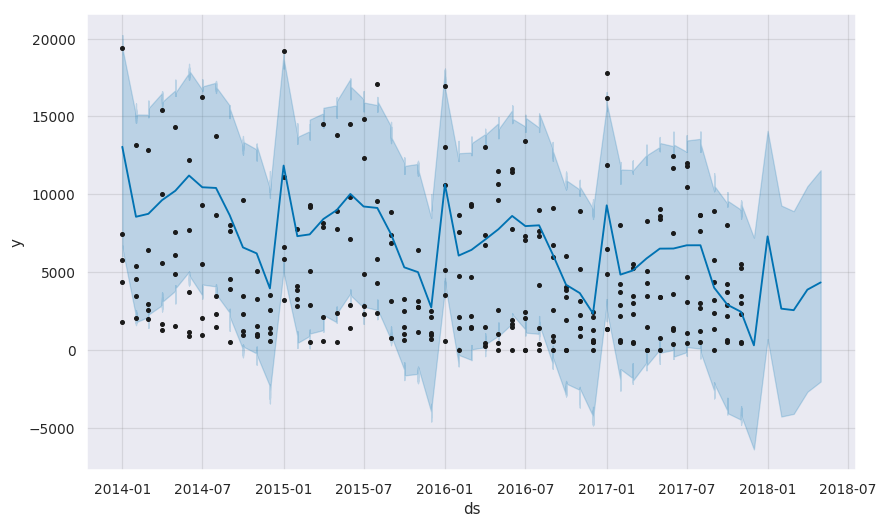

In [51]:
# visualizing predicions
east_model.plot(forecast);

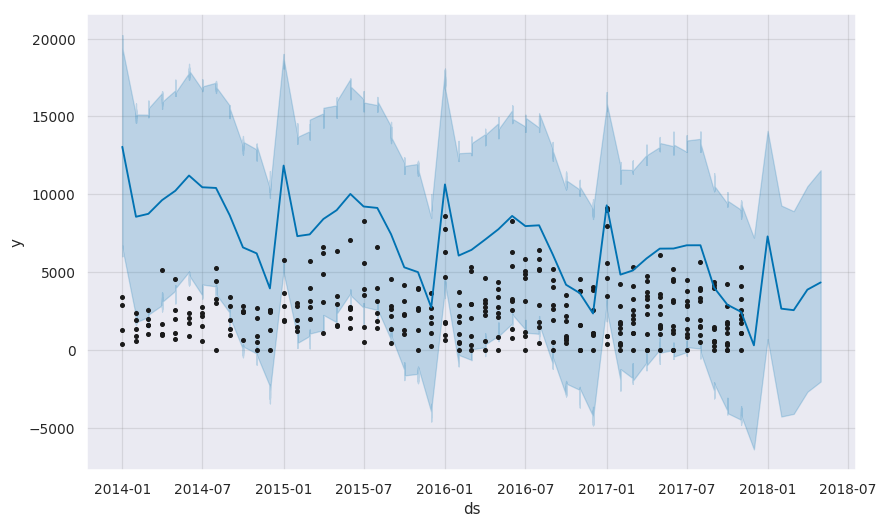

In [52]:
# visualizing predicions
west_model.plot(forecast);

As we see Prophet catches the trends and most of the time gets future values right.

One other particularly strong feature of Prophet is its ability to return the components of our forecasts. This can help reveal how daily, weekly and yearly patterns of the time series plus manyally included holidayes contribute to the overall forecasted values:

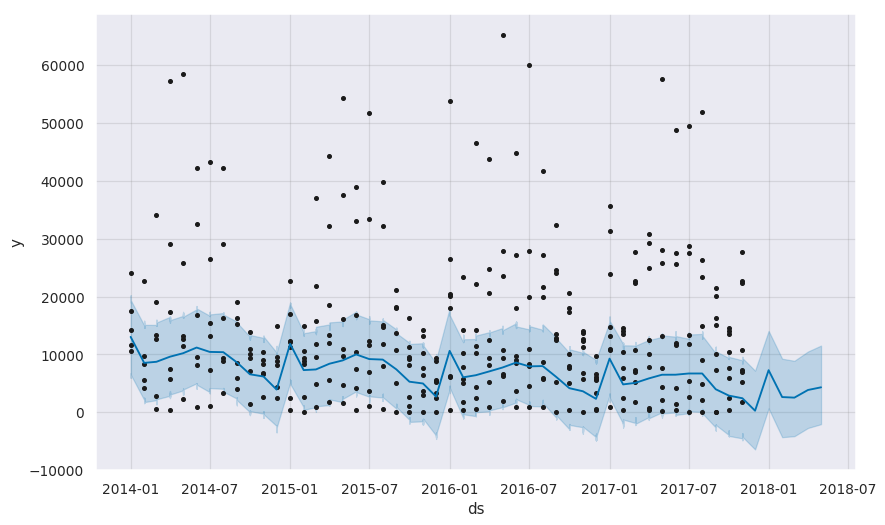

In [53]:
# visualizing predicions
inner_model.plot(forecast);

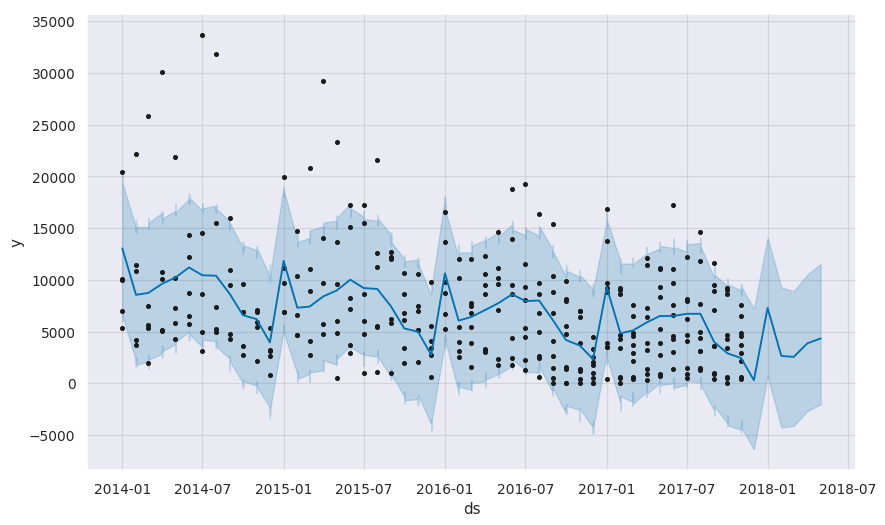

In [54]:
# visualizing predicions
north_model.plot(forecast);

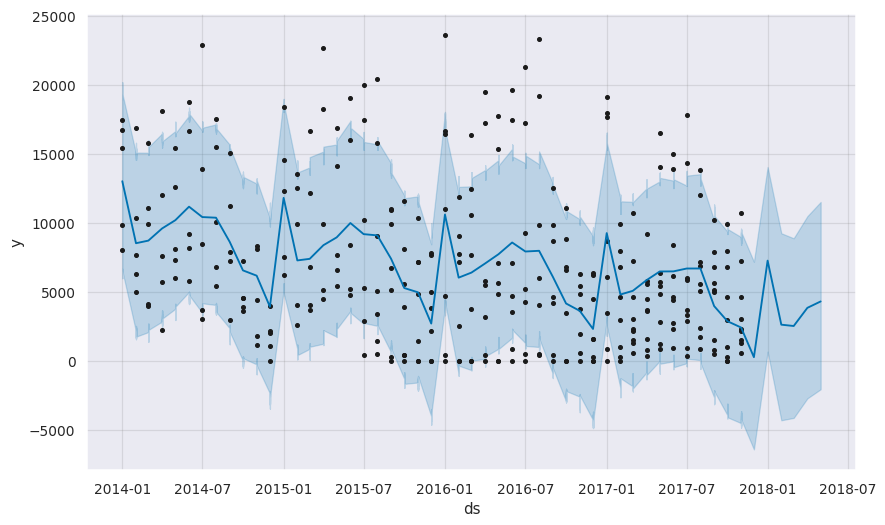

In [55]:
# visualizing predicions
south_model.plot(forecast);

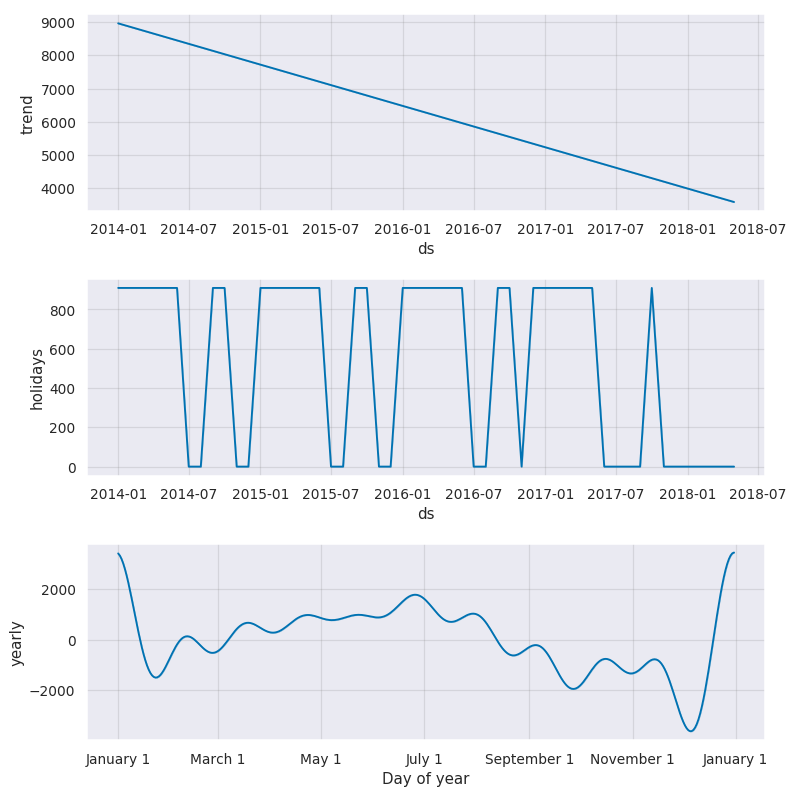

In [56]:
east_model.plot_components(forecast);

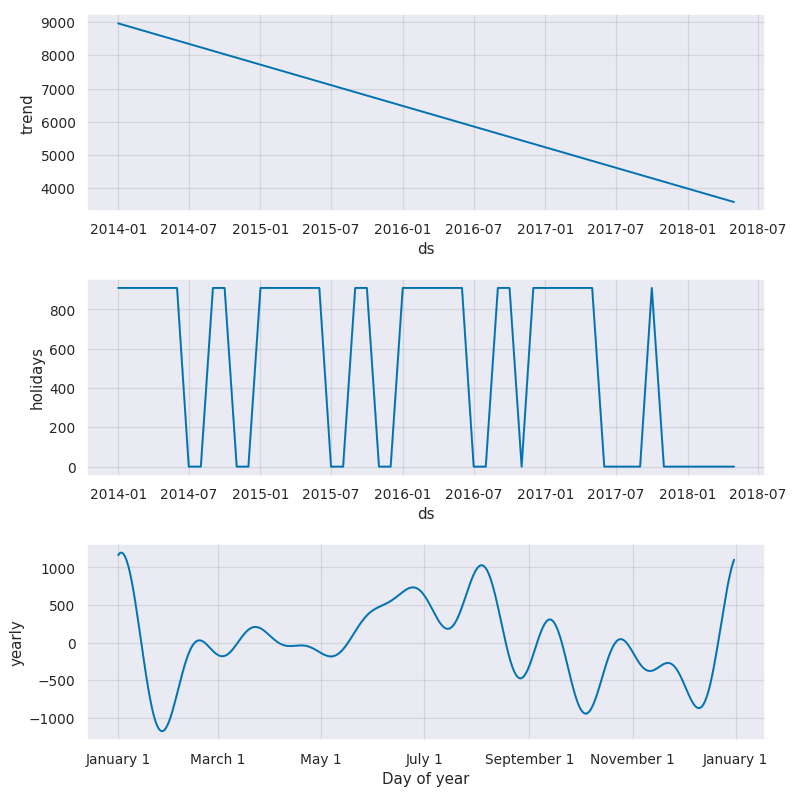

In [57]:

west_model.plot_components(forecast);

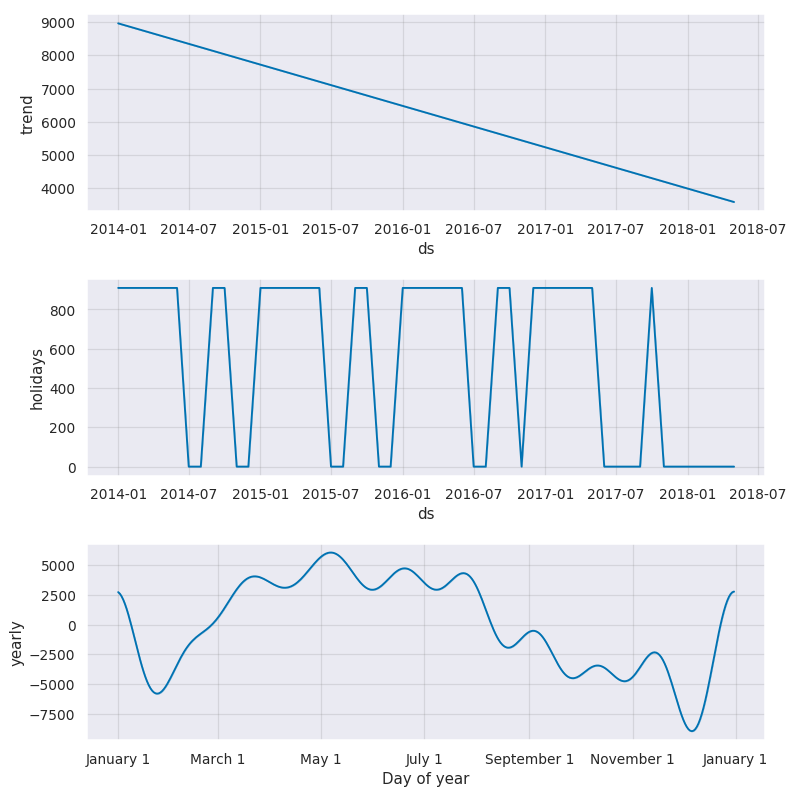

In [58]:
inner_model.plot_components(forecast);

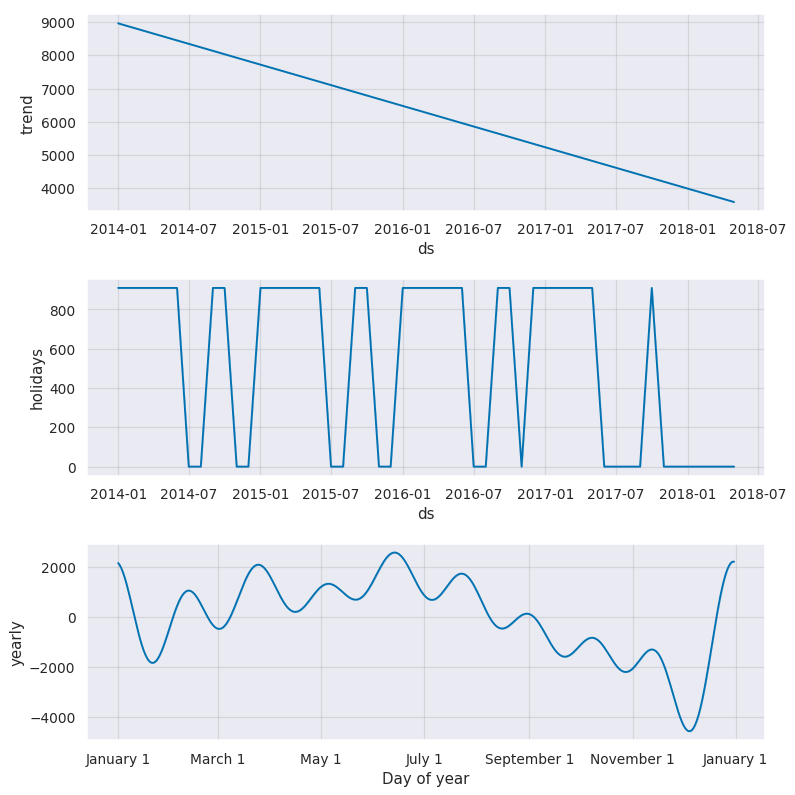

In [59]:
north_model.plot_components(forecast);

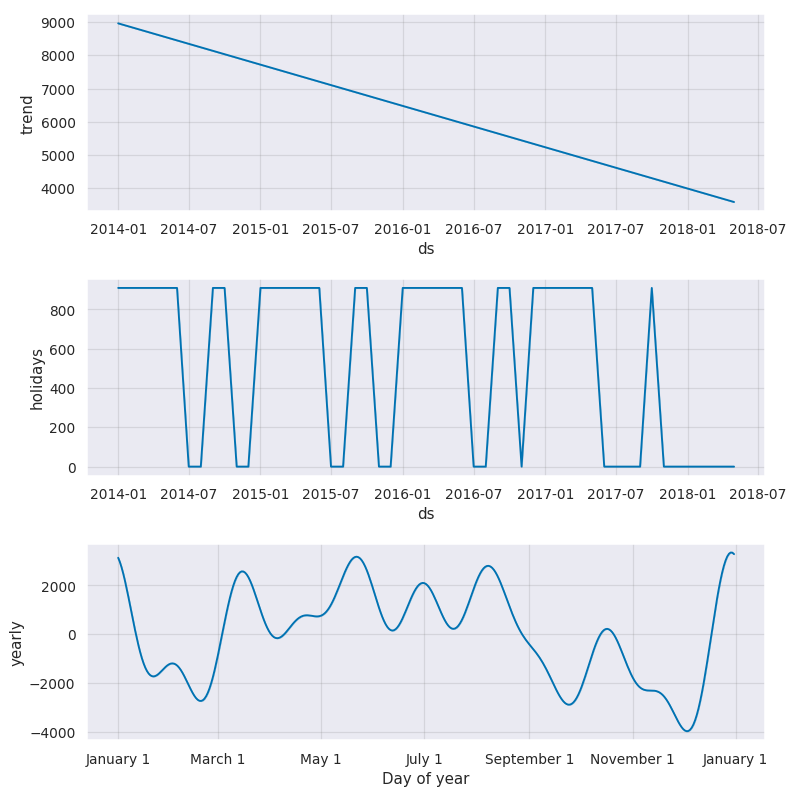

In [60]:
south_model.plot_components(forecast);


The first plot shows that the monthly sales of store number 1 has been linearly decreasing  over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the yearly volume of trend.

### Performance Matrics

In [73]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
pd.set_option('display.float_format',lambda x : '%.2f' % x)
forecast_all = shipment_model.predict(future_dates)

# print(forecast_all)

def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast"""
    return forecast_all.set_index('ds')[['yhat','yhat_lower','yhat_lower']].join(historical.set_index('ds'))
    
cmp_df = make_comparison_dataframe(shipment, forecast_all)

cmp_df.tail(50)

# c = '#386B7F'

# sns.catplot(data = forecast_all, x = 'ds', y = "yhat", 
#                col = 'HolidayDay', # per HolidayDays in cols
#                palette = 'plasma',
#                hue = 'ItemCode',
#                row = 'Package',
              
#                color = c) 

# cmp_df.tail(49)

# m = Prophet(seasonality_mode='multiplicative', holidays=holidays).fit(shipment)
# df_cv = cross_validation(m, initial='600 days', period='180 days', horizon = '365 days')
# df_cv.head(55)


# train = performance_metrics(train)
# train.head()

,yhat,yhat_lower,yhat_lower,y,ItemCode,Region,BrandCode
ds,,,,,,,
2017-11-01,3657.12,-2473.26,-2473.26,4083.93,9310070030.00,West,33.00
2017-11-01,3657.12,-2673.22,-2673.22,2301.39,2111256114.00,East,33.00
2017-11-01,3657.12,-2673.22,-2673.22,460.92,2992101565.00,East,34.00
2017-11-01,3657.12,-2673.22,-2673.22,3019.63,3747832079.00,East,34.00
2017-11-01,3657.12,-2673.22,-2673.22,479.73,5203395462.00,East,33.00
2017-11-01,3657.12,-2673.22,-2673.22,5513.03,5763825994.00,East,33.00
2017-11-01,3657.12,-2673.22,-2673.22,3478.24,6179328252.00,East,34.00
2017-11-01,3657.12,-2673.22,-2673.22,5275.64,9310070030.00,East,33.00
2017-11-01,3657.12,-2673.22,-2673.22,5227.22,1698579415.00,Inner,53.00


In [66]:

# df_p = performance_metrics(df_cv)
# df_p.head(55)

In [67]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')


NameError: name 'df_cv' is not defined

### Conclusion of Time Series forecasting

During this part we discussed time series analysis with `.seasonal_decompose()`, `ACF` and `PCF` plots and fited forecasting model using a new procedure by Facebook `Prophet`.

We can now present main advantages and drawbacks of time series forecasting:

__Advantages__
- Powerfull tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet: manualy).
- Easily implemented with `auto.arima()` from `forecast` package, which runs a complex grid search and sophisticated algorythm behind the scene.

__Drawbacks__
- Doesn't catch interactions between external features, which could improve the forecasting power of a model. Even in our case, we don't have this question, but these variables like `Special` and `CompetitionOpen` or `Special Holiday`. 
- Eventhough Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.
- Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the the biggest drawback for new companies.
- Seasonal ARIMA in Python has 7 hyperparameters which can be tuned only manually affecting significantly the speed of the forecasting process.

## Alternative Approach: Regression XGBoost

[XGBoost](https://github.com/dmlc/xgboost/blob/master/doc/model.md) is an implementation of Gradient Boosted Decision trees designed for speed and performance. Its more suitable name is a as [regularized Gradient Boosting](http://datascience.la/xgboost-workshop-and-meetup-talk-with-tianqi-chen/), as it uses a more regularized model formalization to control over-fitting. 

Additional advantages of this algorythm are:

- Automated missing values handling: XGB uses a "learned" default direction for the missing values. "Learned" means learned in the tree construction process by choosing the best direction that optimizes the training loss.
- Interactive feature analysis (yet implemented only in R): plots the structure of decision trees with splits and leaves.
- Feature importance analysis: a sorted barplot of the most significant variables.

<div class = "alert alert-block alert-info"> As we already saw in the previos section our data is higly seasonal and not random (dependent). Therefore, before fitting any models we need to "smooth" target variable Sales. The typical preprocessing step is to log transform the data in question. Once we perform the forecasting we will unwind log transformations in reverse order. </div>

### Quick Run through

In [45]:
from sklearn.model_selection import train_test_split
# to predict to
# dataset = pd.read_csv("/home/CORPUSERS/28850775/Documents/data-sci/data/ResultDataMonth_train.csv", 
#                     parse_dates = True, low_memory = False, index_col = 'YearMonth')
dataset = pd.read_csv("/home/robin/Documents/data-sci/C_Team/sales_forcecasting/sales_forcecast/EDA-master/data/ResultDataMonth.csv", 
                    parse_dates = True, low_memory = False, index_col = 'YearMonth')

train,test = train_test_split(dataset,test_size=0.2)

# msk = np.random.rand(len(train)) < 0.8
# train = train[msk]
# test = train[~msk]
print(train.shape)
print(test.shape)

test.head()

(1264, 11)
(316, 11)


,Region,ItemCode,BrandCode,Package,ShipQty,SalesQty,Year,Month,Quarter,HolidayDay,IsHoliday
YearMonth,,,,,,,,,,,
2016-07-01,South,2111256114,33,pack2,9283.5215,5527.3560,2016,7,3,0,0
2016-11-01,East,9310070030,33,pack1,5198.5664,31336.8790,2016,11,4,0,0
2014-08-01,East,2111256114,33,pack2,3485.6489,1089.5725,2014,8,3,0,0
2014-05-01,East,2111256114,33,pack2,6113.1191,26282.8110,2014,5,2,4,1
2015-03-01,East,5763825994,33,pack1,9281.5557,16192.8720,2015,3,1,1,1


Even ETL process has been done, we don't need it anymore, just simply follow the process. 

In [46]:
# test: missing values? just a double check
test.isnull().sum()

Region        0
ItemCode      0
BrandCode     0
Package       0
ShipQty       0
SalesQty      0
Year          0
Month         0
Quarter       0
HolidayDay    0
IsHoliday     0
dtype: int64

In [47]:
test[pd.isnull(test.ShipQty ==0)]

,Region,ItemCode,BrandCode,Package,ShipQty,SalesQty,Year,Month,Quarter,HolidayDay,IsHoliday
YearMonth,,,,,,,,,,,


### Data Encoding

XGBoost doesn't support anything else than numbers. So prior to modeling we need to encode certain factor variables into numerical plus extract dates as we did before for the train set.

In [48]:
# data extraction
# test['Year'] = test.index.year
# test['Month'] = test.index.month
# test['Day'] = test.index.day
# test['WeekOfYear'] = test.index.weekofyear
# to numerical
mappings = {'East':0, 'West':1, 'Inner':2, 'North':3, 'South':4} 
mappings_pkg = {'pack1':0, 'pack2':1, 'pack3':2, 'pack4':3}

# test.StateHoliday.replace(mappings, inplace = True)
train.Region.replace(mappings, inplace = True) 
train.Package.replace(mappings_pkg, inplace = True)
test.Region.replace(mappings, inplace = True)
test.Package.replace(mappings_pkg, inplace = True)
print(train)
# train_store.Assortment.replace(mappings, inplace = True)
# train_store.StoreType.replace(mappings, inplace = True)
# train_store.StateHoliday.replace(mappings, inplace = True)
# train_store.drop('PromoInterval', axis = 1, inplace = True)
# store.StoreType.replace(mappings, inplace = True)
# store.Assortment.replace(mappings, inplace = True)
# store.drop('PromoInterval', axis = 1, inplace = True)

            Region    ItemCode  BrandCode  Package      ShipQty  \
YearMonth                                                         
2016-08-01       3  5763825994         33        0   8634.55860   
2016-04-01       1  2992101565         34        2    559.25879   
2017-10-01       2  6288617494         33        3    346.99829   
2016-04-01       4  5763825994         33        0  19516.95300   
2014-05-01       2  6179328252         34        0  12632.06700   
2017-09-01       4  5676563080         33        2    832.90479   
2016-03-01       1  6179328252         34        0    886.09790   
2017-08-01       4  5763825994         33        0  12052.55900   
2014-02-01       3  9310070030         33        0  22190.51400   
2015-05-01       0  6179328252         34        0   7772.80520   
2015-10-01       2  6179328252         34        0   9273.45210   
2015-05-01       1  5763825994         33        0   3428.49000   
2017-05-01       1  2992101565         34        2   1001.4205

Returning back to the `train` data:

### Model Training

#### Approach

1. Split train data to train and test set to evaluate the model.
2. Set `eta` to a relatively high value (e.g. 0.05 ~ 0.1), num_round to 300 ~ 500
3. Use grid search to find the best combination of additional parameters.
4. Lower `eta` until we reach the optimum.
5. Use the validation set as watchlist to retrain the model with the best parameters. 

In [49]:
# split into training and evaluation sets
# excluding Sales and Id columns
predictors = [x for x in train.columns if x not in [ 'ShipQty',]]
y = np.log(train.SalesQty) # log transformation of Sales
X = train
# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)
y_train.replace(-np.inf,1, inplace=True)
y_train.fillna(0,inplace=True)

# y_train[~train([np.nan,np.inf,-np.inf]).any(1)]
print(y_train)

YearMonth
2014-08-01     5.492282
2016-10-01    11.656242
2017-03-01     6.930615
2014-01-01     9.810684
2015-07-01     7.967041
2014-09-01     8.743392
2016-12-01     7.634612
2015-05-01     6.062209
2014-03-01     7.116640
2017-04-01     8.435675
2015-08-01     8.477979
2017-05-01     5.811755
2017-08-01     9.631517
2015-04-01     6.324897
2017-05-01     8.786626
2016-01-01     6.235084
2017-04-01     6.452793
2015-12-01     9.710431
2015-12-01     1.000000
2016-10-01     4.871340
2015-04-01    10.812146
2015-01-01     9.880515
2017-07-01     7.536784
2016-12-01     8.966219
2015-09-01     8.121820
2015-06-01     6.459588
2015-12-01     9.131487
2015-12-01     7.168594
2016-08-01    10.227242
2015-06-01     8.623713
                ...    
2015-03-01     8.685785
2017-09-01     8.019516
2014-07-01     8.440967
2014-05-01     8.899482
2017-01-01     9.747255
2015-12-01     1.000000
2016-12-01     1.000000
2017-06-01     7.026654
2017-10-01     7.547802
2016-08-01     8.479660
2014-0

In [50]:
# predictors
X[predictors].columns

Index(['Region', 'ItemCode', 'BrandCode', 'Package', 'SalesQty', 'Year',
       'Month', 'Quarter', 'HolidayDay', 'IsHoliday'],
      dtype='object')

In [51]:
# evaluation metric: rmspe
# Root Mean Square Percentage Error
# code chunk shared at Kaggle

# def rmspe(y, yhat):
#     return np.sqrt(np.mean((yhat / y-1) ** 2))

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def RMSPE(y, yhat):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmse(y, yhat):
    return np.sqrt(np.mean((y-yhat / y) ** 2))

def mse(y,yhat):
    return (1-np.sum((yhat-y)/y))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", metric_RMSPE(y, yhat)

def metric_RMSPE(y, yhat):

    y1 = np.array(yhat)
    y2 = np.array(y)
    n = len(y)
    temp = np.square((y1 - y2)/y2).sum()
    score = np.sqrt(temp/n)
    return score



#### Tuning Parameters

-  `eta`: Step size used in updating weights. Lower value means slower training but better convergence. 
- `num_round`: Total number of iterations.
- `subsample`: The ratio of training data used in each iteration; combat overfitting. Should be configured in the range of 30% to 80% of the training dataset, and compared to a value of 100% for no sampling.
- `colsample_bytree`: The ratio of features used in each iteration, default 1.
- `max_depth`: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
- `early_stopping_rounds`: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.

In [52]:
# base parameters
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [53]:
# XGB with xgboost library
dtrain = xgb.DMatrix(X_train[predictors], y_train)
dtest = xgb.DMatrix(X_test[predictors], y_test)
watchlist = [(dtrain, 'train'), (dtest, 'test')]


xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      early_stopping_rounds = 100, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.08182	test-rmse:inf	train-rmspe:0.981399	test-rmspe:1.0572
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:6.38117	test-rmse:inf	train-rmspe:0.978385	test-rmspe:1.06355
[2]	train-rmse:5.74956	test-rmse:inf	train-rmspe:0.974671	test-rmspe:1.06894
[3]	train-rmse:5.18085	test-rmse:inf	train-rmspe:0.970037	test-rmspe:1.07315
[4]	train-rmse:4.66904	test-rmse:inf	train-rmspe:0.964161	test-rmspe:1.07588
[5]	train-rmse:4.20725	test-rmse:inf	train-rmspe:0.956642	test-rmspe:1.07686
[6]	train-rmse:3.79102	test-rmse:inf	train-rmspe:0.947103	test-rmspe:1.07575
[7]	train-rmse:3.41757	test-rmse:inf	train-rmspe:0.935343	test-rmspe:1.07232
[8]	train-rmse:3.08044	test-rmse:inf	train-rmspe:0.920998	test-rmspe:1.06627
[9]	train-rmse:2.77609	test-rmse:inf	train-rmspe:0.903863	test-rmspe:1.05756
[10]	train-rmse:2.51463	test-rmse:inf	train-rmspe:0.882888	test-rmspe:1.09774
[11]	tr

[102]	train-rmse:0.006985	test-rmse:inf	train-rmspe:0.007034	test-rmspe:0.694399
[103]	train-rmse:0.006801	test-rmse:inf	train-rmspe:0.006851	test-rmspe:0.694373
[104]	train-rmse:0.006671	test-rmse:inf	train-rmspe:0.006723	test-rmspe:0.694326
[105]	train-rmse:0.006555	test-rmse:inf	train-rmspe:0.006609	test-rmspe:0.694301
[106]	train-rmse:0.006434	test-rmse:inf	train-rmspe:0.006487	test-rmspe:0.694302
[107]	train-rmse:0.006359	test-rmse:inf	train-rmspe:0.006411	test-rmspe:0.694309
[108]	train-rmse:0.00627	test-rmse:inf	train-rmspe:0.006322	test-rmspe:0.694269
[109]	train-rmse:0.006171	test-rmse:inf	train-rmspe:0.006223	test-rmspe:0.694264
[110]	train-rmse:0.006037	test-rmse:inf	train-rmspe:0.006089	test-rmspe:0.694238
[111]	train-rmse:0.005911	test-rmse:inf	train-rmspe:0.00596	test-rmspe:0.694258
[112]	train-rmse:0.005717	test-rmse:inf	train-rmspe:0.005769	test-rmspe:0.694232
[113]	train-rmse:0.00562	test-rmse:inf	train-rmspe:0.005673	test-rmspe:0.694228
[114]	train-rmse:0.005554	test-

[204]	train-rmse:0.001221	test-rmse:inf	train-rmspe:0.001254	test-rmspe:0.694467
[205]	train-rmse:0.001194	test-rmse:inf	train-rmspe:0.001227	test-rmspe:0.694471
[206]	train-rmse:0.001178	test-rmse:inf	train-rmspe:0.001209	test-rmspe:0.694467
[207]	train-rmse:0.001163	test-rmse:inf	train-rmspe:0.001196	test-rmspe:0.69447
[208]	train-rmse:0.001157	test-rmse:inf	train-rmspe:0.001189	test-rmspe:0.694473
[209]	train-rmse:0.001145	test-rmse:inf	train-rmspe:0.001177	test-rmspe:0.694476
[210]	train-rmse:0.001129	test-rmse:inf	train-rmspe:0.001162	test-rmspe:0.694475
[211]	train-rmse:0.001113	test-rmse:inf	train-rmspe:0.001146	test-rmspe:0.694478
[212]	train-rmse:0.001092	test-rmse:inf	train-rmspe:0.001125	test-rmspe:0.694483
[213]	train-rmse:0.001084	test-rmse:inf	train-rmspe:0.001117	test-rmspe:0.694483
[214]	train-rmse:0.001071	test-rmse:inf	train-rmspe:0.001104	test-rmspe:0.694487
[215]	train-rmse:0.001068	test-rmse:inf	train-rmspe:0.001101	test-rmspe:0.69449
Stopping. Best iteration:
[115

Last rows:

`
[178]	train-rmse:0.00171	test-rmse:inf	train-rmspe:0.001733	test-rmspe:0.639756
[179]	train-rmse:0.001695	test-rmse:inf	train-rmspe:0.001719	test-rmspe:0.639791
[180]	train-rmse:0.001649	test-rmse:inf	train-rmspe:0.001672	test-rmspe:0.639797
[181]	train-rmse:0.001618	test-rmse:inf	train-rmspe:0.001642	test-rmspe:0.639794
[182]	train-rmse:0.001579	test-rmse:inf	train-rmspe:0.001603	test-rmspe:0.639778
[183]	train-rmse:0.001549	test-rmse:inf	train-rmspe:0.001573	test-rmspe:0.639768
[184]	train-rmse:0.001521	test-rmse:inf	train-rmspe:0.001545	test-rmspe:0.639771
[185]	train-rmse:0.001492	test-rmse:inf	train-rmspe:0.001517	test-rmspe:0.639774
[186]	train-rmse:0.001461	test-rmse:inf	train-rmspe:0.001485	test-rmspe:0.639774
[187]	train-rmse:0.001458	test-rmse:inf	train-rmspe:0.001483	test-rmspe:0.639776
Stopping. Best iteration:
[87]	train-rmse:0.010402	test-rmse:inf	train-rmspe:0.010487	test-rmspe:0.63965
`

Essentially, we want the least value. The model with base hyperparameters gives out better result on the train set, indicating to the overfitting issue. 

### Grid Search from sklearn

Scikit learn wrapper is famous for the `GridSearchCV` and `RandomizedSearchCV`. Between these two, most of the time the [preference leans towards `RandomnizedSearchCV`](https://stats.stackexchange.com/questions/160479/practical-hyperparameter-optimization-random-vs-grid-search), faster version of `GridSearchCV`. 

As an input, `RandomnizedSearchCV` takes only sklearn wrapper of XGboost, so instead of using the first version of a model, we build the analogous model in sklearn with `XGBRegressor`.

In [54]:
# XGB with sklearn wrapper
# the same parameters as for xgboost model
params_sk = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}     

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.85, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.8)

For parameters we will specify the regularization parameter `reg_alpha` which reduce model complexity and enhance performance, as well as `gamma` parameter which represents the minimum loss reduction required to make a split and also `max_depth` used to control over-fitting.

In [55]:
import scipy.stats as st

params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(X_train, y_train)
# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

{'gamma': 2.2165196563548584, 'learning_rate': 0.29641313683706394, 'max_depth': 10, 'reg_alpha': 19.74085080496329}
0.9806121742651694


In [56]:
# with new parameters
params_new = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', 
    'subsample': 0.8, 
    'colsample_bytree': 0.85, 
    'eta': 0.08106924075327354, 
    'max_depth': 16, 
    'gamma': 2.0946975593149473,
    'reg_alpha': 2.1037132201029216,
    'seed': 42} 

model_final = xgb.train(params_new, dtrain, 300, evals = watchlist,
                        early_stopping_rounds = 200, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.22995	test-rmse:inf	train-rmspe:0.982399	test-rmspe:1.05087
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 200 rounds.
[1]	train-rmse:6.64986	test-rmse:inf	train-rmspe:0.980285	test-rmspe:1.05472
[2]	train-rmse:6.11996	test-rmse:inf	train-rmspe:0.977786	test-rmspe:1.05797
[3]	train-rmse:5.63122	test-rmse:inf	train-rmspe:0.974651	test-rmspe:1.06059
[4]	train-rmse:5.18119	test-rmse:inf	train-rmspe:0.970852	test-rmspe:1.06302
[5]	train-rmse:4.76677	test-rmse:inf	train-rmspe:0.966303	test-rmspe:1.06377
[6]	train-rmse:4.38572	test-rmse:inf	train-rmspe:0.960791	test-rmspe:1.06328
[7]	train-rmse:4.03615	test-rmse:inf	train-rmspe:0.953916	test-rmspe:1.06236
[8]	train-rmse:3.71337	test-rmse:inf	train-rmspe:0.945797	test-rmspe:1.05923
[9]	train-rmse:3.41759	test-rmse:inf	train-rmspe:0.935976	test-rmspe:1.05455
[10]	train-rmse:3.15942	test-rmse:inf	train-rmspe:0.921983	test-rmspe:1.08887
[11]	t

[102]	train-rmse:0.121387	test-rmse:inf	train-rmspe:0.146913	test-rmspe:0.833846
[103]	train-rmse:0.121381	test-rmse:inf	train-rmspe:0.146977	test-rmspe:0.834009
[104]	train-rmse:0.121381	test-rmse:inf	train-rmspe:0.146977	test-rmspe:0.834009
[105]	train-rmse:0.121381	test-rmse:inf	train-rmspe:0.146977	test-rmspe:0.834009
[106]	train-rmse:0.121381	test-rmse:inf	train-rmspe:0.146977	test-rmspe:0.834009
[107]	train-rmse:0.121381	test-rmse:inf	train-rmspe:0.146977	test-rmspe:0.834009
[108]	train-rmse:0.121377	test-rmse:inf	train-rmspe:0.147024	test-rmspe:0.834129
[109]	train-rmse:0.121376	test-rmse:inf	train-rmspe:0.14704	test-rmspe:0.83417
[110]	train-rmse:0.121366	test-rmse:inf	train-rmspe:0.147162	test-rmspe:0.83448
[111]	train-rmse:0.121366	test-rmse:inf	train-rmspe:0.147162	test-rmspe:0.83448
[112]	train-rmse:0.121364	test-rmse:inf	train-rmspe:0.147195	test-rmspe:0.834564
[113]	train-rmse:0.121361	test-rmse:inf	train-rmspe:0.147236	test-rmspe:0.834666
[114]	train-rmse:0.121361	test-r

[204]	train-rmse:0.121341	test-rmse:inf	train-rmspe:0.147622	test-rmspe:0.835627
[205]	train-rmse:0.121341	test-rmse:inf	train-rmspe:0.147622	test-rmspe:0.835627
[206]	train-rmse:0.121341	test-rmse:inf	train-rmspe:0.147622	test-rmspe:0.835627
[207]	train-rmse:0.121341	test-rmse:inf	train-rmspe:0.147622	test-rmspe:0.835627
[208]	train-rmse:0.121341	test-rmse:inf	train-rmspe:0.147622	test-rmspe:0.835627
[209]	train-rmse:0.121342	test-rmse:inf	train-rmspe:0.147604	test-rmspe:0.835584
[210]	train-rmse:0.12134	test-rmse:inf	train-rmspe:0.147633	test-rmspe:0.835656
[211]	train-rmse:0.121339	test-rmse:inf	train-rmspe:0.14767	test-rmspe:0.835747
[212]	train-rmse:0.121339	test-rmse:inf	train-rmspe:0.14767	test-rmspe:0.835747
[213]	train-rmse:0.121338	test-rmse:inf	train-rmspe:0.147689	test-rmspe:0.835793
[214]	train-rmse:0.121338	test-rmse:inf	train-rmspe:0.147689	test-rmspe:0.835793
[215]	train-rmse:0.121338	test-rmse:inf	train-rmspe:0.147689	test-rmspe:0.835793
[216]	train-rmse:0.121338	test-

Last five rows:
    
`
[194]	train-rmse:0.785001	test-rmse:inf	train-rmspe:inf	test-rmspe:321.57
[195]	train-rmse:0.785001	test-rmse:inf	train-rmspe:inf	test-rmspe:321.57
[196]	train-rmse:0.785001	test-rmse:inf	train-rmspe:inf	test-rmspe:321.227
[197]	train-rmse:0.785001	test-rmse:inf	train-rmspe:inf	test-rmspe:321.233
[198]	train-rmse:0.784922	test-rmse:inf	train-rmspe:inf	test-rmspe:321.238
[199]	train-rmse:0.783896	test-rmse:inf	train-rmspe:inf	test-rmspe:322.145
[200]	train-rmse:0.783602	test-rmse:inf	train-rmspe:inf	test-rmspe:323.357
Stopping. Best iteration:
[0]	train-rmse:7.48443	test-rmse:inf	train-rmspe:inf	test-rmspe:1.08594
`

We resolved an issue with overfitting, but due to the decrease of learning rate (`eta`) we got a bit worse overall score on the test set (~0.11 to ~0.14).

In [57]:
yhat = model_final.predict(xgb.DMatrix(X_test[predictors]))


error = RMSPE(X_test.SalesQty.values, np.exp(yhat))
print('First validation yelds RMSPE: {:.6f}'.format(error))


First validation yelds RMSPE: 0.081063


Even though we observed a bit higher RMSPE value, we need to remember that the corresponding `eta` for the first version was 0.1, which is usually considered as high. I think that it's remarkable that we got more or less the same result but with 2x lower `eta` (0.1 to 0.04).

__Next steps towards model's improvement will involve further decrease of `eta`, tuning of correpsonding `gamma` and `max_depth`.__

### Model understanding

Feature importance scores help us see which variables contributed the most to the score.

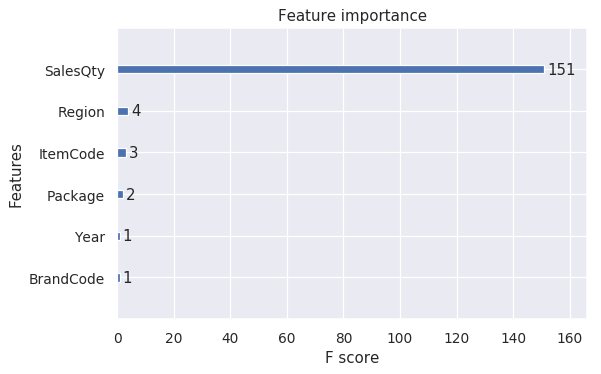

In [58]:
xgb.plot_importance(model_final)

Variables `ItemCode` and `Month` are both leading. Then go features `Region`,  `Year`, `HolidayDay`, `Package` ,`BrandCode`,`Quarter`,and deducted features `IsHoliday`.

### predict the data on next month by region and ItemCode

In [83]:
from sklearn.model_selection import train_test_split

train_m = xgb.DMatrix(train[predictors])
train_p = model_final.predict(train_m)
forecasts = pd.DataFrame({'ShipQty':np.exp(train_p),'ItemCode':train['ItemCode'],'Region':train['Region']}).sort_values(by=['ItemCode','Region','YearMonth'])
forecasts.sort_index(ascending=False)
# print(forecasts['2017-04-01'])
forecasts['2017-11-01'].head(12)


,ShipQty,ItemCode,Region
YearMonth,,,
2017-11-01,2439.976318,1211831394,1
2017-11-01,1178.438599,1211831394,4
2017-11-01,85.053238,1698579415,1
2017-11-01,2693.444824,1698579415,2
2017-11-01,232.980652,1698579415,3
2017-11-01,1376.125732,2111256114,0
2017-11-01,5815.713379,2111256114,1
2017-11-01,26960.353516,2111256114,2
2017-11-01,1506.760254,2111256114,4


### Prediction to unseen data

In [61]:
from sklearn.model_selection import train_test_split
# to predict to
# dataset = pd.read_csv("/home/CORPUSERS/28850775/Documents/data-sci/data/ResultDataMonth_train.csv", 
#                     parse_dates = True, low_memory = False, index_col = 'YearMonth')

dataset = train
train,test = train_test_split(dataset,test_size=0.2)
# predictions to unseen data

# mappings = {'East':0, 'West':1, 'Inner':2, 'North':3, 'South':4} 
# mappings_pkg = {'pack1':0, 'pack2':1, 'pack3':2, 'pack4':3}
# test.Region.replace(mappings, inplace = True)
# test.Package.replace(mappings_pkg, inplace = True)
unseen = xgb.DMatrix(test[predictors])
test_p = model_final.predict(unseen)
forecasts = pd.DataFrame({'ShipQty': np.exp(test_p), 
                          'SalesQty': test['SalesQty']})
# forecasts
forecasts.head(12)

,ShipQty,SalesQty
YearMonth,,
2015-06-01,18127.066406,20152.775000
2016-10-01,21083.447266,23489.717000
2014-04-01,3.770542,0.000000
2016-08-01,3.294816,0.000000
2016-06-01,6823.988281,6822.172400
2014-09-01,1058.282593,1063.009600
2017-04-01,656.763672,634.471740
2017-11-01,1126.259888,1116.926400
2014-02-01,17491.031250,17985.830000


## Alternative another approach of LSTM 

In [78]:
import os 
import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Activation, Dropout, Flatten, TimeDistributed,RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
from pandas import HDFStore
import numpy as np 



Using TensorFlow backend.


## Feature Engineering

In [79]:
# dataset = pd.read_csv("/home/robin/Documents/data-sci/C_Team/sales_forcecasting/sales_forcecast/EDA-master/data/ResultDataMonth.csv", 
#                     parse_dates = True, low_memory = False, index_col = 'YearMonth')

# train,test = train_test_split(dataset,test_size=0.2)

# mappings = {'East':0, 'West':1, 'Inner':2, 'North':3, 'South':4} 
# mappings_pkg = {'pack1':0, 'pack2':1, 'pack3':2, 'pack4':3}

# # test.StateHoliday.replace(mappings, inplace = True)
# train.Region.replace(mappings, inplace = True) 
# train.Package.replace(mappings_pkg, inplace = True)
# test.Region.replace(mappings, inplace = True)
# test.Package.replace(mappings_pkg, inplace = True)
# print(train)
def normarlize():
    train_norm = train.apply(lambda x: (x-np.mean(x)/(np.max(x) - np.min(x))))
    return train_norm 


def shuffle(X,Y):
    np.random.seed(20)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(units = 1,  activation = 'relu', input_shape =(1,11)))
#     model.add(Flatten())
    model.add(Dense(1))
    model.add(Dropout(0.5))
    model.compile(loss="mse",optimizer="adam")
    
    model.summary()
    return model


### splite data & training 

In [80]:
predictors = [x for x in train.columns if x not in [ 'SalesQty']]
y = np.log(train.SalesQty) # log transformation of Sales
X = train[predictors]

# print(X)
# print('===========================')
# print(y_train)
# print('==============================')
# print(y_train.shape)
# # split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)
print(X_train.shape, y_train.shape,  X_test.shape, y_test.shape)
y_train.replace(-np.inf,1, inplace=True)
y_train.fillna(0,inplace=True)
# callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
# X_train = X_train.



model = buildManyToOneModel(X_train.shape)
# print(X_train.shape)
# print(X_train.values)
X_train=X_train.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
# X_train = X_train.values.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
# X_train = np.reshape(X_train,(-1,1, X_train.shape[1]))
# X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
model.fit(X_train, y_train, epochs=100, batch_size= 884, verbose=1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


(184, 10) (184,) (79, 10) (79,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1)                 52        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1)                 0         
Total params: 54
Trainable params: 54
Non-trainable params: 0
_________________________________________________________________


AttributeError: 'DataFrame' object has no attribute 'reshape'

---

## Final thoughts

Time Series Analysis is a must for time series data. It goes much deeper than ad-hoc Exploratory Data Analysis, revealing trends, non randomness of the data and seasonalities.

I was particularly excited to use a new forecasting procedure Prophet. Eventhough this tool is still under development, it has everything set for the advanced modeling as it can account for change points in trends and holidays in the data. In the meantime, the most sophisticated tool for the Time Series Analysis stays auto.arima from R forecast package.

A significant jump in the forecasting performance of the model fitted above, XGboost with xgboost library, can be achieved by increasing the number and range of hyperparameters. Due to the number of observations (800k) and with a laptop like mine, the "more developped" grid search would take about 2-3 days to fit. So I left this room for the improvement for later notebooks.

Another method that I didn't cover here is a regression model Stacking, which works great for small or medium size data sets. We would basically combine XGboost, RandomForest, NN and SVM for regression. And then stack them together by building the final model.